## The code for figure 3 - studying the engagement with the null model

In [2]:

import h5py
import xarray as xr
import xgi
import mne
import numpy as np
import scipy.stats as stats
import scipy
import pandas as pd
from os.path import join as pjoin
from itertools import product
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
import matplotlib.cm as cm
import random
import os
import pickle
import warnings 
import matplotlib
from lempel_ziv_complexity import lempel_ziv_complexity
import seaborn as sns

import saving as sv
import mattepy as mp
import utils_avalanches as av
import Utils_FC as fc

warnings.simplefilter('ignore')

#path='/home/jeremy/anaconda3/matteo/'
path='C:/Users/matte/OneDrive/Documenti/matteo/'
#CREATING THE LIST OF SUBJECTS

## Functions to compute O-info

In [3]:
"""Dynamic and task-related higher-order interactions."""
from math import comb

import numpy as np
import scipy as sp
import xarray as xr

import itertools
from mne.utils import ProgressBar

from frites.conn import conn_io
from frites.io import logger, check_attrs
from frites.core import mi_nd_gg, mi_model_nd_gd, copnorm_nd 
from frites.utils import parallel_func
from frites.core import copnorm_nd

from frites.config import CONFIG


def ent_g(x, biascorrect=True):
    """Entropy of a tensor of shape (..., n_vars, n_trials)"""
    nvarx, ntrl = x.shape[-2], x.shape[-1]

    # covariance
    c = np.einsum('...ij, ...kj->...ik', x, x)
    c /= float(ntrl - 1.)
    chc = np.linalg.cholesky(c)

    # entropy in nats
    hx = np.log(np.einsum('...ii->...i', chc)).sum(-1) + 0.5 * nvarx * (
        np.log(2 * np.pi) + 1.0)

    ln2 = np.log(2)
    if biascorrect:
        psiterms = sp.special.psi((ntrl - np.arange(1, nvarx + 1).astype(
            float)) / 2.) / 2.
        dterm = (ln2 - np.log(ntrl - 1.)) / 2.
        hx = hx - nvarx * dterm - psiterms.sum()

    return hx

def _mi_estimation(x, y, mi_type, mvaxis=None):
    """Compute the MI on each roi.
    x.shape = (n_times, {1, Nd}, n_trials)
    y.shape = ({1, Nd}, n_trials)
    """
    x = np.ascontiguousarray(x)
    cfg_mi = CONFIG["KW_GCMI"]
    if mi_type == 'cc':
        y = np.atleast_2d(y)[np.newaxis, ...]
        # repeat y to match x shape
        y = np.tile(y, (x.shape[0], 1, 1))
        return mi_nd_gg(x, y, **cfg_mi)
    elif mi_type == 'cd':
        return mi_model_nd_gd(x, y, **cfg_mi)

def compute_syn(x, y, mi_type):
    """Compute the synergy among HOIs.
    """
    
    # size
    n_roi = x.shape[1]

    # total information for multiple
    mi_tot = _mi_estimation(x, y, mi_type, mvaxis=-2)
    
    # total information for -j 
    mi_tot_j = np.zeros(x.shape[0:2])
    for i in range(n_roi):
        ind_j = np.setdiff1d(range(n_roi), i)
        x_j = x[:, ind_j, :]
        mi_tot_j[:, i] = _mi_estimation(x_j, y, mi_type, mvaxis=-2)
    max_mi_tot_j = np.max(mi_tot_j, axis=-1)

    # Synergy
    syn = mi_tot - max_mi_tot_j

    return syn

def compute_oinfo(x, ind):
    """Compute the O-info.
    x.shape = (..., n_vars, n_trials)
    ind = indices for tensor-computations
    """
    nvars = x.shape[-2]
    o = (nvars - 2) * ent_g(x)
    o += (ent_g(x[..., np.newaxis, :]) - ent_g(x[..., ind, :])).sum(1)
    return o


def combinations(n, k, roi, task_related=False):
    """Get combinations."""
    combs = np.array(list(itertools.combinations(np.arange(n), k)))

    # add behavior as a final columns
    if task_related:
        combs = np.c_[combs, np.full((combs.shape[0],), n)]

    # build brain region names
    roi_st = ['-'.join(r) for r in roi[combs].tolist()]

    return combs, roi_st


def conn_hoi_oinfo(data, y=None, times=None, roi=None, minsize=3, maxsize=5,
             verbose=None):
    """Dynamic, possibly task-related, higher-order interactions.
    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :
            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)
    y : array_like
        The feature of shape (n_trials,) for estimating task-related O-info.
    roi : array_like | None
        Array of region of interest name of shape (n_roi,)
    times : array_like | None
        Array of time points of shape (n_times,)
    minsize, maxsize : int | 3, 5
        Minimum and maximum size of the multiplets
    Returns
    -------
    oinfo : array_like
        The O-info array of shape (n_multiplets, n_times) where positive values
        reflect redundant dominated interactions and negative values stand for
        synergistic dominated interactions.
    """
    # ________________________________ INPUTS _________________________________
    # inputs conversion
    is_task_related = isinstance(y, (str, list, np.ndarray, tuple))
    kw_links = {'directed': False, 'net': False}
    data, cfg = conn_io(
        data, y=y, times=times, roi=roi, name='DynOinfo', verbose=verbose,
        kw_links=kw_links
    )

    # extract variables
    x, attrs = data.data, cfg['attrs']
    y, roi, times = data['y'].data, data['roi'].data, data['times'].data
    n_roi, n_times = len(roi), len(times)

    # get the maximum size of the multiplets investigated
    if not isinstance(maxsize, int):
        maxsize = n_roi
    maxsize = max(1, maxsize)
    assert maxsize > minsize

    # get the number of multiplets
    n_mults = 0
    for msize in range(minsize, maxsize + 1):
        n_mults += comb(n_roi, msize)
    pbar = ProgressBar(range(n_mults))

    logger.info(f"Compute the {'task-related ' * is_task_related} HOI "
                f"(min={minsize}; max={maxsize})")

    # ________________________________ O-INFO _________________________________
    logger.info("    Copnorm the data")

    # for task-related, add behavior along spatial dimension
    if is_task_related:
        y = np.tile(y.reshape(-1, 1, 1), (1, 1, len(times)))
        x = np.concatenate((x, y), axis=1)
        roi = np.r_[roi, ['beh']]

    # copnorm and demean the data
    x = copnorm_nd(x.copy(), axis=0)
    x = (x - x.mean(axis=0, keepdims=True))

    # make the data (n_times, n_roi, n_trials)
    x = x.transpose(2, 1, 0)

    oinfo, roi_o = [], []
    for msize in range(minsize, maxsize + 1):
        # ------------------------------ INDICES ------------------------------
        ish = msize if not is_task_related else msize + 1
        ind = np.zeros((ish, ish), dtype=int)
        vec = np.arange(ish)
        for shift in range(ish):
            ind[shift, :] = np.roll(vec, -shift)
        ind = ind[:, 1:]

        # ----------------------------- MULTIPLETS ----------------------------
        logger.info(f"    Multiplets of size {msize}")
        combs, _roi_o = combinations(
            n_roi, msize, roi, task_related=is_task_related)
        roi_o += _roi_o

        # ------------------------------- O-INFO ------------------------------
        _oinfo = np.zeros((comb(n_roi, msize), n_times))
        for n_m, mult in enumerate(combs):
            _oinfo[n_m, :] = compute_oinfo(x[:, mult, :], ind)
            pbar.update_with_increment_value(1)

        oinfo.append(_oinfo)
    oinfo = np.concatenate(oinfo, axis=0)

    # _______________________________ OUTPUTS _________________________________
    attrs.update(dict(
        task_related=is_task_related, minsize=minsize, maxsize=maxsize
    ))
    oinfo = xr.DataArray(
        oinfo, dims=('roi', 'times'), coords=(roi_o, times), name="Oinfo",
        attrs=check_attrs(attrs)
    )

    return oinfo

def conn_hoi_red(data, y=None, times=None, roi=None, mi_type='cc', gcrn=True,
                 minsize=3, maxsize=5, verbose=None):
    """Redundancy among higher-order interactions.
    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :
            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)
    y : array_like
        The feature of shape (n_trials,) for estimating task-related O-info.
    roi : array_like | None
        Array of region of interest name of shape (n_roi,)
    mi_type : {'cc', 'cd'}
        Mutual information type. Switch between :
            * 'cc' : if the y input is a continuous regressor
            * 'cd' : if the y input is a discret vector with categorical
              integers inside
    gcrn : bool | True
        Specify if the Gaussian Copula Rank Normalization should be applied.
        Default is True.
    times : array_like | None
        Array of time points of shape (n_times,)
    minsize, maxsize : int | 3, 5
        Minimum and maximum size of the multiplets
    Returns
    -------
    oinfo : array_like
        The O-info array of shape (n_multiplets, n_times) where positive values
        reflect redundant dominated interactions and negative values stand for
        synergistic dominated interactions.
    """
    # ________________________________ INPUTS _________________________________
    # inputs conversion
    kw_links = {'directed': False, 'net': False}
    data, cfg = conn_io(
        data, y=y, times=times, roi=roi, name='Red', verbose=verbose,
        kw_links=kw_links
    )

    # extract variables
    x, attrs = data.data, cfg['attrs']
    y, roi, times = data['y'].data, data['roi'].data, data['times'].data
    n_roi, n_times = len(roi), len(times)

    # get the maximum size of the multiplets investigated
    if not isinstance(maxsize, int):
        maxsize = n_roi
    maxsize = max(1, maxsize)
    assert maxsize > minsize

    # get the number of multiplets
    n_mults = 0
    for msize in range(minsize, maxsize + 1):
        n_mults += comb(n_roi, msize)

    logger.info(f"Compute HOI redundancy"
                f"(min={minsize}; max={maxsize})")

    # ________________________________ Red _________________________________
    logger.info("    Copnorm the data")
    
    # gcrn
    if gcrn:
        logger.info("    Apply the Gaussian Copula Rank Normalization")
        x = copnorm_nd(x, axis=0)
        if mi_type == 'cc':
            y = copnorm_nd(y, axis=0)

    # make the data (n_times, n_roi, n_trials)
    x = x.transpose(1, 2, 0)

    # compute mi on each node of the network
    mi_node = np.zeros((n_roi, n_times), dtype=float)
    for n_r in range(n_roi):
        mi_node[n_r, :] = _mi_estimation(x[n_r, :, np.newaxis, :], y, mi_type)

    # Loop over multiples
    red, roi_o = [], []
    for msize in range(minsize, maxsize + 1):

        # ------------------------------ INDICES ------------------------------
        ish = msize + 1
        ind = np.zeros((ish, ish), dtype=int)
        vec = np.arange(ish)
        for shift in range(ish):
            ind[shift, :] = np.roll(vec, -shift)
        ind = ind[:, 1:]

        # ----------------------------- MULTIPLETS ----------------------------
        logger.info(f"    Multiplets of size {msize}")
        combs, _roi_o = combinations(n_roi, msize, roi)
        roi_o += _roi_o

        # --------------------------- RED using MMI ---------------------------
        _red = np.zeros((comb(n_roi, msize), n_times))
        for n_m, mult in enumerate(combs):
            _red[n_m, :] = np.min(mi_node[mult, :], axis=0)
        red.append(_red)

    red = np.concatenate(red, axis=0)

    # _______________________________ OUTPUTS _________________________________
    attrs.update(dict(minsize=minsize, maxsize=maxsize))
    red = xr.DataArray(
        red, dims=('roi', 'times'), coords=(roi_o, times), name="Red",
        attrs=check_attrs(attrs)
    )

    return red

def conn_hoi_syn(data, y=None, times=None, roi=None, mi_type='cc', gcrn=True,
                 minsize=3, maxsize=5, verbose=None):
    """Synergy among higher-order interactions.
    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :
            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)
    y : array_like
        The feature of shape (n_trials,) for estimating task-related O-info.
    roi : array_like | None
        Array of region of interest name of shape (n_roi,)
    mi_type : {'cc', 'cd'}
        Mutual information type. Switch between :
            * 'cc' : if the y input is a continuous regressor
            * 'cd' : if the y input is a discret vector with categorical
              integers inside
    gcrn : bool | True
        Specify if the Gaussian Copula Rank Normalization should be applied.
        Default is True.
    times : array_like | None
        Array of time points of shape (n_times,)
    minsize, maxsize : int | 3, 5
        Minimum and maximum size of the multiplets
    Returns
    -------
    oinfo : array_like
        The O-info array of shape (n_multiplets, n_times) where positive values
        reflect redundant dominated interactions and negative values stand for
        synergistic dominated interactions.
    """
    # ________________________________ INPUTS _________________________________
    # inputs conversion
    kw_links = {'directed': False, 'net': False}
    data, cfg = conn_io(
        data, y=y, times=times, roi=roi, name='Red', verbose=verbose,
        kw_links=kw_links
    )

    # extract variables
    x, attrs = data.data, cfg['attrs']
    y, roi, times = data['y'].data, data['roi'].data, data['times'].data
    n_roi = len(roi)

    # get the maximum size of the multiplets investigated
    if not isinstance(maxsize, int):
        maxsize = n_roi
    maxsize = max(1, maxsize)
    assert maxsize > minsize

    # get the number of multiplets
    n_mults = 0
    for msize in range(minsize, maxsize + 1):
        n_mults += comb(n_roi, msize)

    logger.info(f"Compute HOI redundancy"
                f"(min={minsize}; max={maxsize})")

    # ________________________________ Syn _________________________________
    logger.info("    Copnorm the data")
    
    # gcrn
    if gcrn:
        logger.info("    Apply the Gaussian Copula Rank Normalization")
        x = copnorm_nd(x, axis=0)
        if mi_type == 'cc':
            y = copnorm_nd(y, axis=0)

    # make the data (n_times, n_roi, n_trials)
    x = x.transpose(2, 1, 0)

    # Loop over multiples
    syn, roi_o = [], []
    for msize in range(minsize, maxsize + 1):

        # ------------------------------ INDICES ------------------------------
        ish = msize + 1
        ind = np.zeros((ish, ish), dtype=int)
        vec = np.arange(ish)
        for shift in range(ish):
            ind[shift, :] = np.roll(vec, -shift)
        ind = ind[:, 1:]

        # ----------------------------- MULTIPLETS ----------------------------
        logger.info(f"    Multiplets of size {msize}")
        combs, _roi_o = combinations(n_roi, msize, roi)
        roi_o += _roi_o

        # --------------------------- SYN using MMI ---------------------------
        _syn = np.zeros((comb(n_roi, msize), n_times))
        for n_m, mult in enumerate(combs):
            _syn[n_m, :] = compute_syn(x[:, mult, :], y, mi_type)
        syn.append(_syn)

    syn = np.concatenate(syn, axis=0)

    # _______________________________ OUTPUTS _________________________________
    attrs.update(dict(minsize=minsize, maxsize=maxsize))
    syn = xr.DataArray(
        syn, dims=('roi', 'times'), coords=(roi_o, times), name="Syn",
        attrs=check_attrs(attrs)
    )

    return syn

## Function to plot hyper graph

In [4]:
"""Draw hypergraphs and simplicial complexes with matplotlib."""
##functions to plot
from collections.abc import Iterable
from inspect import signature
#from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from xgi import convert
from xgi.classes import Hypergraph, SimplicialComplex, max_edge_order
from xgi.exception import XGIError
from xgi.stats import EdgeStat, NodeStat
from xgi.drawing.layout import barycenter_spring_layout

__all__ = [
    "draw",
    "draw_xgi_nodes",
    "draw_xgi_hyperedges",
    "draw_xgi_simplices",
    "draw_node_labels",
    "draw_hyperedge_labels",
]


def draw(
    H,
    pos=None,
    ax=None,
    dyad_color="black",
    dyad_lw=1.5,
    edge_fc=None,
    node_fc="white",
    node_ec="black",
    node_lw=1,
    node_size=15,
    max_order=None,
    node_labels=False,
    hyperedge_labels=False,
    **kwargs,
):
    """Draw hypergraph or simplicial complex.
    Parameters
    ----
    H : Hypergraph or SimplicialComplex.
    pos : dict (default=None)
        If passed, this dictionary of positions node_id:(x,y) is used for placing the 0-simplices.
        If None (default), use the `barycenter_spring_layout` to compute the positions.
    ax : matplotlib.pyplot.axes (default=None)
    dyad_color : str, dict, iterable, or EdgeStat (default='black')
        Color of the dyadic links.  If str, use the same color for all edges. If a dict, must
        contain (edge_id: color_str) pairs.  If iterable, assume the colors are
        specified in the same order as the edges are found in H.edges. If EdgeStat, use a colormap
        (specified with dyad_color_cmap) associated to it.
    dyad_lw : int, float, dict, iterable, or EdgeStat (default=1.5)
        Line width of edges of order 1 (dyadic links).  If int or float, use the same width for all edges.
        If a dict, must contain (edge_id: width) pairs.  If iterable, assume the widths are
        specified in the same order as the edges are found in H.edges. If EdgeStat, use a monotonic
        linear interpolation defined between min_dyad_lw and max_dyad_lw.
    edge_fc : str, dict, iterable, or EdgeStat (default=None)
        Color of the hyperedges.  If str, use the same color for all nodes.  If a dict, must
        contain (edge_id: color_str) pairs.  If other iterable, assume the colors are
        specified in the same order as the hyperedges are found in H.edges. If EdgeStat,
        use the colormap specified with edge_fc_cmap. If None (default),
        use the H.edges.size.
    node_fc : str, dict, iterable, or NodeStat (default='white')
        Color of the nodes.  If str, use the same color for all nodes.  If a dict, must
        contain (node_id: color_str) pairs.  If other iterable, assume the colors are
        specified in the same order as the nodes are found in H.nodes. If NodeStat,
        use the colormap specified with node_fc_cmap.
    node_ec : str, dict, iterable, or NodeStat (default='black')
        Color of node borders.  If str, use the same color for all nodes.  If a dict, must
        contain (node_id: color_str) pairs.  If other iterable, assume the colors are
        specified in the same order as the nodes are found in H.nodes. If NodeStat,
        use the colormap specified with node_ec_cmap.
    node_lw : int, float, dict, iterable, or NodeStat (default=1)
        Line width of the node borders in pixels.  If int or float, use the same width for all node borders.
        If a dict, must contain (node_id: width) pairs.  If iterable, assume the widths are
        specified in the same order as the nodes are found in H.nodes. If NodeStat, use a monotonic
        linear interpolation defined between min_node_lw and max_node_lw.
    node_size : int, float, dict, iterable, or NodeStat (default=10)
        Radius of the nodes in pixels.  If int or float, use the same radius for all nodes.
        If a dict, must contain (node_id: radius) pairs.  If iterable, assume the radiuses are
        specified in the same order as the nodes are found in H.nodes. If NodeStat, use a monotonic
        linear interpolation defined between min_node_size and max_node_size.
    max_order : int (default=None)
        Maximum of hyperedges to plot. If None (default), plots all orders.
    node_labels : bool, or dict (default=False)
        If True, draw ids on the nodes. If a dict, must contain (node_id: label) pairs.
    hyperedge_labels : bool, or dict (default=False)
        If True, draw ids on the hyperedges. If a dict, must contain (edge_id: label) pairs.
    **kwargs : optional args
        Alternate default values. Values that can be overwritten are the following:
        * min_node_size
        * max_node_size
        * min_node_lw
        * max_node_lw
        * min_dyad_lw
        * max_dyad_lw
        * node_fc_cmap
        * node_ec_cmap
        * dyad_color_cmap
        * edge_fc_cmap
    Examples
    --------
    >>> import xgi
    >>> H = xgi.Hypergraph()
    >>> H.add_edges_from([[1,2,3],[3,4],[4,5,6,7],[7,8,9,10,11]])
    >>> xgi.draw(H, pos=xgi.barycenter_spring_layout(H))
    See Also
    --------
    draw_xgi_nodes
    draw_xgi_hyperedges
    draw_xgi_simplices
    draw_node_labels
    draw_hyperedge_labels
    """
    settings = {
        "min_node_size": 10.0,
        "max_node_size": 30.0,
        "min_dyad_lw": 2.0,
        "max_dyad_lw": 10.0,
        "min_node_lw": 1.0,
        "max_node_lw": 5.0,
        "node_fc_cmap": cm.Reds,
        "node_ec_cmap": cm.Greys,
        "edge_fc_cmap": cm.Blues,
        "dyad_color_cmap": cm.Greys,
    }

    settings.update(kwargs)

    if edge_fc is None:
        edge_fc = H.edges.size

    if pos is None:
        pos = barycenter_spring_layout(H)

    if ax is None:
        ax = plt.gca()
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.axis("off")

    if not max_order:
        max_order = max_edge_order(H)

    if isinstance(H, SimplicialComplex):
        draw_xgi_simplices(
            H,
            pos,
            ax,
            dyad_color,
            dyad_lw,
            edge_fc,
            max_order,
            settings,
            hyperedge_labels,
            **kwargs,
        )
    elif isinstance(H, Hypergraph):
        draw_xgi_hyperedges(
            H,
            pos,
            ax,
            dyad_color,
            dyad_lw,
            edge_fc,
            max_order,
            settings,
            hyperedge_labels,
            **kwargs,
        )
    else:
        raise XGIError("The input must be a SimplicialComplex or Hypergraph")

    draw_xgi_nodes(
        H,
        pos,
        ax,
        node_fc,
        node_ec,
        node_lw,
        node_size,
        max_order,
        settings,
        node_labels,
        **kwargs,
    )


def draw_xgi_nodes(
    H,
    pos,
    ax,
    node_fc,
    node_ec,
    node_lw,
    node_size,
    zorder,
    settings,
    node_labels,
    **kwargs,
):
    """Draw the nodes of a hypergraph
    Parameters
    ----------
    H : Hypergraph or SimplicialComplex
        Higher-order network to plot.
    ax : matplotlib.pyplot.axes
    pos : dict
        Dictionary of positions node_id:(x,y) of every node.
    node_fc : str, dict, iterable, or NodeStat
        Color of the nodes.  If str, use the same color for all nodes.  If a dict, must
        contain (node_id: color_str) pairs.  If other iterable, assume the colors are
        specified in the same order as the nodes are found in H.nodes. If NodeStat,
        use the colormap specified with node_fc_cmap.
    node_ec : str, dict, iterable, or NodeStat (default='black')
        Color of node borders.  If str, use the same color for all nodes.  If a dict, must
        contain (node_id: color_str) pairs.  If other iterable, assume the colors are
        specified in the same order as the nodes are found in H.nodes. If NodeStat,
        use the colormap specified with node_ec_cmap.
    node_lw : int, float, dict, iterable, or EdgeStat (default=1)
        Line width of the node borders in pixels.  If int or float, use the same width for all node borders.
        If a dict, must contain (node_id: width) pairs.  If iterable, assume the widths are
        specified in the same order as the nodes are found in H.nodes. If NodeStat, use a monotonic
        linear interpolation defined between min_node_lw and max_node_lw.
    node_size : int, float, dict, iterable, or NodeStat (default=10)
        Radius of the nodes in pixels.  If int or float, use the same radius for all nodes.
        If a dict, must contain (node_id: radius) pairs.  If iterable, assume the radiuses are
        specified in the same order as the nodes are found in H.nodes. If NodeStat, use a monotonic
        linear interpolation defined between min_node_size and max_node_size.
    zorder : int
        The layer on which to draw the nodes.
    node_labels : bool, or dict
        If True, draw ids on the nodes. If a dict, must contain (node_id: label) pairs.
    settings : dict
        Default parameters. Keys that may be useful to override default settings:
        * min_node_size
        * max_node_size
        * min_node_lw
        * max_node_lw
        * node_fc_cmap
        * node_ec_cmap
    kwargs : optional keywords
        See `draw_node_labels` for a description of optional keywords.
    See Also
    --------
    draw
    draw_xgi_hyperedges
    draw_xgi_simplices
    draw_node_labels
    draw_hyperedge_labels
    """
    # Note Iterable covers lists, tuples, ranges, generators, np.ndarrays, etc
    node_fc = _color_arg_to_dict(node_fc, H.nodes, settings["node_fc_cmap"])
    node_ec = _color_arg_to_dict(node_ec, H.nodes, settings["node_ec_cmap"])
    node_lw = _scalar_arg_to_dict(
        node_lw,
        H.nodes,
        settings["min_node_lw"],
        settings["max_node_lw"],
    )
    node_size = _scalar_arg_to_dict(
        node_size, H.nodes, settings["min_node_size"], settings["max_node_size"]
    )

    x, y, s, c, ec, lw, = zip(
        *[
            (
                pos[i][0],
                pos[i][1],
                node_size[i] ** 2,
                node_fc[i],
                node_ec[i],
                node_lw[i],
            )
            for i in H.nodes
        ]
    )
    ax.scatter(x=x, y=y, s=s, c=c, edgecolors=ec, linewidths=lw, zorder=zorder)

    if node_labels:
        # Get all valid keywords by inspecting the signatures of draw_node_labels
        valid_label_kwds = signature(draw_node_labels).parameters.keys()
        # Remove the arguments of this function (draw_networkx)
        valid_label_kwds = valid_label_kwds - {"H", "pos", "ax", "node_labels"}
        if any([k not in valid_label_kwds for k in kwargs]):
            invalid_args = ", ".join([k for k in kwargs if k not in valid_label_kwds])
            raise ValueError(f"Received invalid argument(s): {invalid_args}")
        label_kwds = {k: v for k, v in kwargs.items() if k in valid_label_kwds}
        draw_node_labels(H, pos, node_labels, ax_nodes=ax, **label_kwds)


def draw_xgi_hyperedges(
    H,
    pos,
    ax,
    dyad_color,
    dyad_lw,
    edge_fc,
    max_order,
    settings,
    hyperedge_labels,
    **kwargs,
):
    """Draw hyperedges.
    Parameters
    ----------
    H : Hypergraph
    ax : matplotlib.pyplot.axes
    pos : dict
        Dictionary of positions node_id:(x,y) of every node.
    dyad_color : str, dict, iterable, or EdgeStat
        Color of the dyadic links.  If str, use the same color for all edges. If a dict, must
        contain (edge_id: color_str) pairs.  If iterable, assume the colors are
        specified in the same order as the edges are found in H.edges. If EdgeStat, use a colormap
        (specified with dyad_color_cmap) associated to it.
    dyad_lw : int, float, dict, iterable, or EdgeStat
        Line width of edges of order 1 (dyadic links).  If int or float, use the same width for all edges.
        If a dict, must contain (edge_id: width) pairs.  If iterable, assume the widths are
        specified in the same order as the edges are found in H.edges. If EdgeStat, use a monotonic
        linear interpolation defined between min_dyad_lw and max_dyad_lw.
    edge_fc : str, dict, iterable, or EdgeStat (default=None)
        Color of the hyperedges.  If str, use the same color for all nodes.  If a dict, must
        contain (edge_id: color_str) pairs.  If other iterable, assume the colors are
        specified in the same order as the hyperedges are found in H.edges. If EdgeStat,
        use the colormap specified with edge_fc_cmap.
    max_order : int
        Maximum of hyperedges to plot.
    hyperedge_labels : bool, or dict
        If True, draw ids on the hyperedges. If a dict, must contain (edge_id: label) pairs.
    settings : dict
        Default parameters. Keys that may be useful to override default settings:
        * min_dyad_lw
        * max_dyad_lw
        * dyad_color_cmap
        * edge_fc_cmap
    kwargs : optional keywords
        See `draw_hyperedge_labels` for a description of optional keywords.
    Raises
    ------
    XGIError
        If a SimplicialComplex is passed.
    See Also
    --------
    draw
    draw_xgi_nodes
    draw_xgi_simplices
    draw_node_labels
    draw_hyperedge_labels
    """

    if not max_order:
        max_order = max_edge_order(H)

    dyad_color = _color_arg_to_dict(dyad_color, H.edges, settings["dyad_color_cmap"])
    dyad_lw = _scalar_arg_to_dict(
        dyad_lw, H.edges, settings["min_dyad_lw"], settings["max_dyad_lw"]
    )

    edge_fc = _color_arg_to_dict(edge_fc, H.edges, settings["edge_fc_cmap"])

    # Looping over the hyperedges of different order (reversed) -- nodes will be plotted separately
    for id, he in H.edges.members(dtype=dict).items():
        d = len(he) - 1
        if d > max_order:
            continue
        if d == 1:
            # Drawing the edges
            he = list(he)
            x_coords = [pos[he[0]][0], pos[he[1]][0]]
            y_coords = [pos[he[0]][1], pos[he[1]][1]]
            line = plt.Line2D(
                x_coords,
                y_coords,
                color=dyad_color[id],
                lw=dyad_lw[id],
                zorder=max_order - 1,
            )
            ax.add_line(line)
        else:
            # Hyperedges of order d (d=2: triangles, etc.)
            # Filling the polygon
            coordinates = [[pos[n][0], pos[n][1]] for n in he]
            # Sorting the points counterclockwise (needed to have the correct filling)
            sorted_coordinates = _CCW_sort(coordinates)
            obj = plt.Polygon(
                sorted_coordinates,
                facecolor=edge_fc[id],
                alpha=0.4,
                zorder=max_order - d,
            )
            ax.add_patch(obj)

    if hyperedge_labels:
        # Get all valid keywords by inspecting the signatures of draw_node_labels
        valid_label_kwds = signature(draw_hyperedge_labels).parameters.keys()
        # Remove the arguments of this function (draw_networkx)
        valid_label_kwds = valid_label_kwds - {"H", "pos", "ax", "hyperedge_labels"}
        if any([k not in valid_label_kwds for k in kwargs]):
            invalid_args = ", ".join([k for k in kwargs if k not in valid_label_kwds])
            raise ValueError(f"Received invalid argument(s): {invalid_args}")
        label_kwds = {k: v for k, v in kwargs.items() if k in valid_label_kwds}
        draw_hyperedge_labels(H, pos, hyperedge_labels, ax_edges=ax, **label_kwds)


def draw_xgi_simplices(
    SC,
    pos,
    ax,
    dyad_color,
    dyad_lw,
    edge_fc,
    max_order,
    settings,
    hyperedge_labels,
    **kwargs,
):
    """Draw maximal simplices and pairwise faces.
    Parameters
    ----------
    SC : SimplicialComplex
    ax : matplotlib.pyplot.axes
    pos : dict
        Dictionary of positions node_id:(x,y) of every node.
    dyad_color : str, dict, iterable, or EdgeStat
        Color of the dyadic links.  If str, use the same color for all edges. If a dict, must
        contain (edge_id: color_str) pairs.  If iterable, assume the colors are
        specified in the same order as the edges are found in H.edges. If EdgeStat, use a colormap
        (specified with dyad_color_cmap) associated to it.
    dyad_lw : int, float, dict, iterable, or EdgeStat
        Line width of edges of order 1 (dyadic links).  If int or float, use the same width for all edges.
        If a dict, must contain (edge_id: width) pairs.  If iterable, assume the widths are
        specified in the same order as the edges are found in H.edges. If EdgeStat, use a monotonic
        linear interpolation defined between min_dyad_lw and max_dyad_lw.
    edge_fc : str, dict, iterable, or EdgeStat (default=None)
        Color of the hyperedges.  If str, use the same color for all nodes.  If a dict, must
        contain (edge_id: color_str) pairs.  If other iterable, assume the colors are
        specified in the same order as the hyperedges are found in H.edges. If EdgeStat,
        use the colormap specified with edge_fc_cmap.
    max_order : int
        Maximum of hyperedges to plot.
    hyperedge_labels : bool, or dict
        If True, draw ids on the hyperedges. If a dict, must contain (edge_id: label) pairs.
        Note, we plot only the maximal simplices so if you pass a dict be careful to match its keys
        with the new edge ids in the converted SimplicialComplex. These may differ from the
        edge ids in the given SC.
    settings : dict
        Default parameters. Keys that may be useful to override default settings:
        * min_dyad_lw
        * max_dyad_lw
        * dyad_color_cmap
        * edge_fc_cmap
    kwargs : optional keywords
        See `draw_hyperedge_labels` for a description of optional keywords.
    Raises
    ------
    XGIError
        If a Hypergraph is passed.
    See Also
    --------
    draw
    draw_xgi_nodes
    draw_xgi_hyperedges
    draw_node_labels
    draw_hyperedge_labels
    """

    if max_order:
        max_edges = SC.edges.filterby("order", max_order, "leq").members()
        SC = SimplicialComplex(max_edges)  # SC without simplices larger than max_order

    # Plot only the maximal simplices, thus let's convert the SC to H
    H_ = convert.from_simplicial_complex_to_hypergraph(SC)

    if not max_order:
        max_order = max_edge_order(H_)

    dyad_color = _color_arg_to_dict(dyad_color, H_.edges, settings["dyad_color_cmap"])
    dyad_lw = _scalar_arg_to_dict(
        dyad_lw,
        H_.edges,
        settings["min_dyad_lw"],
        settings["max_dyad_lw"],
    )

    edge_fc = _color_arg_to_dict(edge_fc, H_.edges, settings["edge_fc_cmap"])

    # Looping over the hyperedges of different order (reversed) -- nodes will be plotted separately
    for id, he in H_.edges.members(dtype=dict).items():
        d = len(he) - 1

        if d == 1:
            # Drawing the edges
            he = list(he)
            x_coords = [pos[he[0]][0], pos[he[1]][0]]
            y_coords = [pos[he[0]][1], pos[he[1]][1]]

            line = plt.Line2D(
                x_coords,
                y_coords,
                color=dyad_color[id],
                lw=dyad_lw[id],
                zorder=max_order - 1,
            )
            ax.add_line(line)
        else:
            # Hyperedges of order d (d=2: triangles, etc.)
            # Filling the polygon
            coordinates = [[pos[n][0], pos[n][1]] for n in he]
            # Sorting the points counterclockwise (needed to have the correct filling)
            sorted_coordinates = _CCW_sort(coordinates)
            obj = plt.Polygon(sorted_coordinates, facecolor=edge_fc[id], alpha=0.4)
            ax.add_patch(obj)
            # Drawing all the edges within
            for i, j in combinations(sorted_coordinates, 2):
                x_coords = [i[0], j[0]]
                y_coords = [i[1], j[1]]
                line = plt.Line2D(
                    x_coords, y_coords, color=dyad_color[id], lw=dyad_lw[id]
                )
                ax.add_line(line)

    if hyperedge_labels:
        # Get all valid keywords by inspecting the signatures of draw_node_labels
        valid_label_kwds = signature(draw_hyperedge_labels).parameters.keys()
        # Remove the arguments of this function (draw_networkx)
        valid_label_kwds = valid_label_kwds - {"H", "pos", "ax", "hyperedge_labels"}
        if any([k not in valid_label_kwds for k in kwargs]):
            invalid_args = ", ".join([k for k in kwargs if k not in valid_label_kwds])
            raise ValueError(f"Received invalid argument(s): {invalid_args}")
        label_kwds = {k: v for k, v in kwargs.items() if k in valid_label_kwds}
        draw_hyperedge_labels(H_, pos, hyperedge_labels, ax_edges=ax, **label_kwds)


def _scalar_arg_to_dict(arg, ids, min_val, max_val):
    """Map different types of arguments for drawing style to a dict with scalar values.
    Parameters
    ----------
    arg : int, float, dict, iterable, or NodeStat/EdgeStat
        Attributes for drawing parameter.
    ids : NodeView or EdgeView
        This is the node or edge IDs that attributes get mapped to.
    min_val : int or float
        The minimum value of the drawing parameter.
    max_val : int or float
        The maximum value of the drawing parameter.
    Returns
    -------
    dict
        An ID: attribute dictionary.
    Raises
    ------
    TypeError
        If a int, float, list, dict, or NodeStat/EdgeStat is not passed.
    """
    if isinstance(arg, dict):
        return {id: arg[id] for id in arg if id in ids}
    elif type(arg) in [int, float]:
        return {id: arg for id in ids}
    elif isinstance(arg, NodeStat) or isinstance(arg, EdgeStat):
        vals = np.interp(arg.asnumpy(), [arg.min(), arg.max()], [min_val, max_val])
        return dict(zip(ids, vals))
    elif isinstance(arg, Iterable):
        return {id: arg[idx] for idx, id in enumerate(ids)}
    else:
        raise TypeError(
            f"Argument must be int, float, dict, iterable, or NodeStat/EdgeStat. Received {type(arg)}"
        )


def _color_arg_to_dict(arg, ids, cmap):
    """Map different types of arguments for drawing style to a dict with color values.
    Parameters
    ----------
    arg : str, dict, iterable, or NodeStat/EdgeStat
        Attributes for drawing parameter.
    ids : NodeView or EdgeView
        This is the node or edge IDs that attributes get mapped to.
    cmap : ListedColormap or LinearSegmentedColormap
        colormap to use for NodeStat/EdgeStat.
    Returns
    -------
    dict
        An ID: attribute dictionary.
    Raises
    ------
    TypeError
        If a string, dict, iterable, or NodeStat/EdgeStat is not passed.
    """
    if isinstance(arg, dict):
        return {id: arg[id] for id in arg if id in ids}
    elif isinstance(arg, str):
        return {id: arg for id in ids}
    elif isinstance(arg, NodeStat) or isinstance(arg, EdgeStat):
        if isinstance(cmap, ListedColormap):
            vals = np.interp(arg.asnumpy(), [arg.min(), arg.max()], [0, cmap.N])
        elif isinstance(cmap, LinearSegmentedColormap):
            vals = np.interp(arg.asnumpy(), [arg.min(), arg.max()], [0.1, 0.9])
        else:
            raise XGIError("Invalid colormap!")

        return {id: np.array(cmap(vals[i])).reshape(1, -1) for i, id in enumerate(ids)}
    elif isinstance(arg, Iterable):
        return {id: arg[idx] for idx, id in enumerate(ids)}
    else:
        raise TypeError(
            f"Argument must be str, dict, iterable, or NodeStat/EdgeStat. Received {type(arg)}"
        )


def _CCW_sort(p):
    """
    Sort the input 2D points counterclockwise.
    """
    p = np.array(p)
    mean = np.mean(p, axis=0)
    d = p - mean
    s = np.arctan2(d[:, 0], d[:, 1])
    return p[np.argsort(s), :]


def draw_node_labels(
    H,
    pos,
    node_labels=False,
    font_size_nodes=10,
    font_color_nodes="black",
    font_family_nodes="sans-serif",
    font_weight_nodes="normal",
    alpha_nodes=None,
    bbox_nodes=None,
    horizontalalignment_nodes="center",
    verticalalignment_nodes="center",
    ax_nodes=None,
    clip_on_nodes=True,
):
    """Draw node labels on the hypergraph or simplicial complex.
    Parameters
    ----------
    H : Hypergraph or SimplicialComplex.
    pos : dict
        Dictionary of positions node_id:(x,y).
    node_labels : bool, or dict (default=False)
        If True, draw ids on the nodes. If a dict, must contain (node_id: label) pairs.
    font_size_nodes : int (default=10)
        Font size for text labels.
    font_color_nodes : str (default='black')
        Font color string.
    font_family_nodes : str (default='sans-serif')
        Font family.
    font_weight_nodes : str (default='normal')
        Font weight.
    alpha_nodes : float (default=None)
        The text transparency.
    bbox_nodes : Matplotlib bbox (default is Matplotlib's ax.text default)
        Specify text box properties (e.g. shape, color etc.) for node labels.
    horizontalalignment_nodes : str (default='center')
        Horizontal alignment {'center', 'right', 'left'}.
    verticalalignment_nodes : str (default='center')
        Vertical alignment {'center', 'top', 'bottom', 'baseline', 'center_baseline'}.
    ax_nodes : matplotlib.pyplot.axes (default=None)
        Draw the graph in the specified Matplotlib axes.
    clip_on_nodes : bool (default=True)
        Turn on clipping of node labels at axis boundaries.
    Returns
    -------
    dict
        `dict` of labels keyed by node id.
    See Also
    --------
    draw
    draw_xgi_nodes
    draw_xgi_hyperedges
    draw_xgi_simplices
    draw_hyperedge_labels
    """
    if ax_nodes is None:
        ax = plt.gca()
    else:
        ax = ax_nodes

    if node_labels is True:
        node_labels = {id: id for id in H.nodes}

    # Plot the labels in the last layer
    zorder = max_edge_order(H) + 1

    text_items = {}
    for id, label in node_labels.items():
        (x, y) = pos[id]

        if not isinstance(label, str):
            label = str(label)

        t = ax.text(
            x,
            y,
            label,
            size=font_size_nodes,
            color=font_color_nodes,
            family=font_family_nodes,
            weight=font_weight_nodes,
            alpha=alpha_nodes,
            horizontalalignment=horizontalalignment_nodes,
            verticalalignment=verticalalignment_nodes,
            transform=ax.transData,
            bbox=bbox_nodes,
            clip_on=clip_on_nodes,
            zorder=zorder,
        )
        text_items[id] = t

    return text_items


def draw_hyperedge_labels(
    H,
    pos,
    hyperedge_labels=False,
    font_size_edges=10,
    font_color_edges="black",
    font_family_edges="sans-serif",
    font_weight_edges="normal",
    alpha_edges=None,
    bbox_edges=None,
    horizontalalignment_edges="center",
    verticalalignment_edges="center",
    ax_edges=None,
    rotate_edges=False,
    clip_on_edges=True,
):
    """Draw hyperedge labels on the hypegraph or simplicial complex.
    Parameters
    ----------
    H : Hypergraph.
    pos : dict
        Dictionary of positions node_id:(x,y).
    hyperedge_labels : bool, or dict (default=False)
        If True, draw ids on the hyperedges. If a dict, must contain (edge_id: label) pairs.
    font_size_edges : int (default=10)
        Font size for text labels.
    font_color_edges : str (default='black')
        Font color string.
    font_family_edges : str (default='sans-serif')
        Font family.
    font_weight_edges : str (default='normal')
        Font weight.
    alpha_edges : float (default=None)
        The text transparency.
    bbox_edges : Matplotlib bbox (default={boxstyle='round', ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0)})
        Specify text box properties (e.g. shape, color etc.) for edge labels.
    horizontalalignment_edges : str (default='center')
        Horizontal alignment {'center', 'right', 'left'}.
    verticalalignment_edges: str (default='center')
        Vertical alignment {'center', 'top', 'bottom', 'baseline', 'center_baseline'}.
    ax_edges : matplotlib.pyplot.axes (default=None)
        Draw the graph in the specified Matplotlib axes.
    rotate_edges : bool (default=False)
        Rotate edge labels for dyadic links to lie parallel to edges.
    clip_on_edges: bool (default=True)
        Turn on clipping of hyperedge labels at axis boundaries.
    Returns
    -------
    dict
        `dict` of labels keyed by hyperedge id.
    See Also
    --------
    draw
    draw_xgi_nodes
    draw_xgi_hyperedges
    draw_xgi_simplices
    draw_node_labels
    """
    if ax_edges is None:
        ax = plt.gca()
    else:
        ax = ax_edges

    if hyperedge_labels is True:
        hyperedge_labels = {id: id for id in H.edges}

    text_items = {}
    for id, label in hyperedge_labels.items():
        he = H.edges.members(id)
        coordinates = [[pos[n][0], pos[n][1]] for n in he]
        x, y = np.mean(coordinates, axis=0)

        if len(he) == 2:
            # Rotate edge labels for dyadic links to lie parallel to edges
            if rotate_edges:
                x_diff, y_diff = np.subtract(coordinates[1], coordinates[0])
                angle = np.arctan2(y_diff, x_diff) / (2.0 * np.pi) * 360
                # Make label orientation "right-side-up"
                if angle > 90:
                    angle -= 180
                if angle < -90:
                    angle += 180
                # Transform data coordinate angle to screen coordinate angle
                xy = np.array((x, y))
                trans_angle = ax.transData.transform_angles(
                    np.array((angle,)), xy.reshape((1, 2))
                )[0]
            else:
                trans_angle = 0.0
        else:
            trans_angle = 0.0

        # Use default box of white with white border
        if bbox_edges is None:
            bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
        else:
            bbox = bbox_edges

        if not isinstance(label, str):
            label = str(label)

        t = ax.text(
            x,
            y,
            label,
            size=font_size_edges,
            color=font_color_edges,
            family=font_family_edges,
            weight=font_weight_edges,
            alpha=alpha_edges,
            horizontalalignment=horizontalalignment_edges,
            verticalalignment=verticalalignment_edges,
            rotation=trans_angle,
            transform=ax.transData,
            bbox=bbox,
            clip_on=clip_on_edges,
        )
        text_items[id] = t

    return text_items

0.000173165958152012


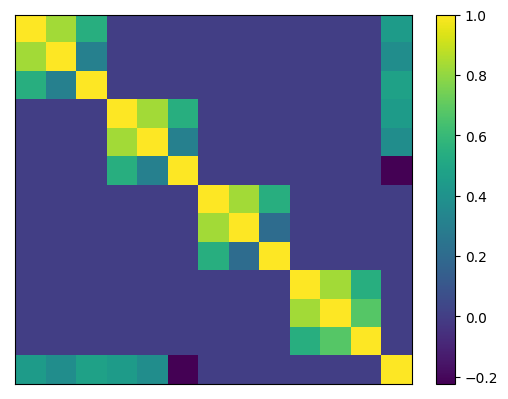

In [5]:
# Simulation mean
mean_mvgauss = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# HOI params
n_trials = 1000
n_roi = 12
n_times=700
cov=np.zeros((13,13))

# Factor loadings
lambx = np.sqrt(0.99)
lamby = np.sqrt(0.7)
lambz = np.sqrt(0.3)
lambs = np.sqrt(0.2)


#FIRST MODULE OF BRAIN REGIONS

# Full factor matrix L
L = np.array([lambx, lamby, lambz])[np.newaxis]

#We fix theta_yz in such a way that O(R1,R2,R3)=0
theta_yz = -0.148 

# Noise covariances theta
theta = np.diagflat(1 - L**2)
theta += np.diagflat([0, theta_yz], 1) + np.diagflat([0, theta_yz], -1)

#The covariance matrix for the three brain regions
cov0 = L * L.T + theta

#We fix theta_yz in such a way that O(R1,R2,R3)<0
theta_yz = -0.25

# Noise covariances theta
theta = np.diagflat(1 - L**2)
theta += np.diagflat([0, theta_yz], 1) + np.diagflat([0, theta_yz], -1)

#The covariance matrix for the three brain regions
cov_red= L * L.T + theta

#We fix theta_yz in such a way that O(R1,R2,R3)>0
theta_yz = 0.22 

# Noise covariances theta
theta = np.diagflat(1 - L**2)
theta += np.diagflat([0, theta_yz], 1) + np.diagflat([0, theta_yz], -1)

#The covariance matrix for the three brain regions
cov_syn= L * L.T + theta

cov[:3,:3]=cov0
cov[3:6,3:6]=cov0
cov[6:9,6:9]=cov_red
cov[9:12,9:12]=cov_syn


#Imposing the relationships with the behaviour
L = np.array([lambx, lamby, lambz, lambs])[np.newaxis]

theta = np.diagflat(1 - L**2) 

#For Red

theta_zs = 0.23

theta += np.diagflat([0, 0, theta_zs], 1) + np.diagflat([0, 0, theta_zs], -1) 

cov_ = L * L.T + theta

cov[:3,12]=cov_[3,:3]
cov[12,:3]=cov_[3,:3]

theta = np.diagflat(1 - L**2) 

#For Syn

theta_zs = -0.47

theta += np.diagflat([0, 0, theta_zs], 1) + np.diagflat([0, 0, theta_zs], -1) 

cov_ = L * L.T + theta

cov[12,3:6]=cov_[3,:3]
cov[3:6,12]=cov_[3,:3]

cov[12,12]=1

plt.imshow(cov, aspect='auto')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.savefig('cov_matrix_12roi_1beh.png', dpi=600)

print(np.linalg.det(cov))

x_brain = np.random.multivariate_normal(mean_mvgauss[:-1], cov[:-1,:-1], size=n_trials, check_valid='warn', tol=1e-8)

x=np.zeros((n_trials, n_roi+1, n_times))

for i in range(n_times):
    x[:,:,i] = np.random.multivariate_normal(mean_mvgauss, cov, size=n_trials, check_valid='warn', tol=1e-8)

beh = x[:,12,:]

#hanning_time = np.repeat(np.repeat(np.hanning(n_times)[np.newaxis,:], n_roi, axis=0)[np.newaxis,:,:], n_trials, axis=0)
#hanning_time_invers = 1-np.repeat(np.repeat((np.hanning(n_times))[np.newaxis,:], n_roi, axis=0)[np.newaxis, :, :],  n_trials, axis=0)

#simulated_data_brain = x_brain * hanning_time_invers + hanning_time * x[:,:12,:]
simulated_data_brain = x[:,:12,:]
simulated_data=x
#simulated_data=np.concatenate((simulated_data_brain, np.repeat(beh[:,np.newaxis, np.newaxis], n_times, axis=2)),axis=1)


([], [])

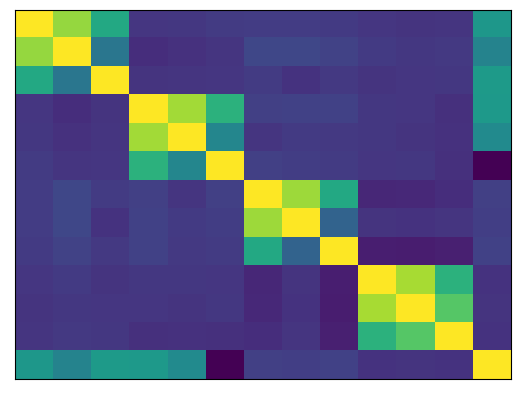

In [6]:
plt.imshow(np.corrcoef(x[:,:,0].T), aspect='auto')
plt.xticks([])
plt.yticks([])

In [7]:
n_times=1
list_roi=[f"R{r+1}" for r in range(n_roi)]
#list_roi.append('beh')

roi = np.array(list_roi)
print(roi)

r456_red=[]
r456_syn=[]
r123_red=[]
r123_syn=[]

oinfo123=[]
oinfo456=[]
oinfo789=[]
oinfo101112=[]

oinfo_gradient123=[]
oinfo_gradient456=[]
oinfo_gradient789=[]
oinfo_gradient101112=[]

r789_red=[]
r789_syn=[]
r101112_red=[]
r101112_syn=[]

r_others_red=[]
r_others_syn=[]

trials = np.arange(n_trials)
times = np.arange(n_times)
for i in range(len(simulated_data[0,0,:100])):
    print('simul numero', i)
    
    simulated_dat_brain=simulated_data_brain[:,:,i][:,:,np.newaxis]
    print(simulated_dat_brain.shape)
    x_simulated = xr.DataArray(simulated_dat_brain, dims=('trials', 'roi', 'times'),
                     coords=(trials, roi, times))
    
    syn = conn_hoi_syn(x_simulated, y=beh[:,i], times='times', roi='roi', minsize=2, maxsize=3, verbose=None)
    
    r123_syn.append(syn.sel(roi='R1-R2-R3').data[0])
    r456_syn.append(syn.sel(roi='R4-R5-R6').data[0])
    r789_syn.append(syn.sel(roi='R7-R8-R9').data[0])
    r101112_syn.append(syn.sel(roi='R10-R11-R12').data[0])
    for rois in syn['roi'].data:
        if 'R1' not in rois and 'R2' not in rois and 'R3' not in rois and 'R4' not in rois and 'R5' not in rois and 'R6' not in rois:
            r_others_syn.append(syn.sel(roi=rois).data[0])
            
            
    red = conn_hoi_red(x_simulated, y=beh[:,i], times='times', roi='roi', minsize=2, maxsize=3, verbose=None)
    
    r123_red.append(red.sel(roi='R1-R2').data[0])
    r456_red.append(red.sel(roi='R4-R5').data[0])
    r789_red.append(red.sel(roi='R7-R8-R9').data[0])
    r101112_red.append(red.sel(roi='R10-R11-R12').data[0])
    
    oinfo = conn_hoi_oinfo(x_simulated, y=beh[:,i], times='times', roi='roi', minsize=2, maxsize=3, verbose=None)
    oinfo123.append(oinfo.sel(roi='R1-R2-R3-beh').data[0])
    oinfo456.append(oinfo.sel(roi='R4-R5-R6-beh').data[0])
    oinfo789.append(oinfo.sel(roi='R7-R8-R9-beh').data[0])
    oinfo101112.append(oinfo.sel(roi='R10-R11-R12-beh').data[0])
    
    oinfo_brain = conn_hoi_oinfo(x_simulated, y=None, times='times', roi='roi', minsize=2, maxsize=3, verbose=None)
    
    oinfo.data = oinfo.data-oinfo_brain.data
    oinfo_gradient123.append(oinfo.sel(roi='R1-R2-R3-beh').data[0])
    oinfo_gradient456.append(oinfo.sel(roi='R4-R5-R6-beh').data[0])
    oinfo_gradient789.append(oinfo.sel(roi='R7-R8-R9-beh').data[0])
    oinfo_gradient101112.append(oinfo.sel(roi='R10-R11-R12-beh').data[0])
    


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3


['R1' 'R2' 'R3' 'R4' 'R5' 'R6' 'R7' 'R8' 'R9' 'R10' 'R11' 'R12']
simul numero 0
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 22%|██▏       |  : 63/286 [00:00<00:00,  490.01it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00,  857.06it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 1
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 16%|█▌        |  : 46/286 [00:00<00:00,  950.59it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 1059.96it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 2
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 14%|█▍        |  : 40/286 [00:00<00:00, 1780.25it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 1355.47it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 3
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 14%|█▎        |  : 39/286 [00:00<00:00, 2198.21it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2316.02it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 4
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 14%|█▍        |  : 40/286 [00:00<00:00, 2406.44it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2589.71it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 5
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 14%|█▍        |  : 40/286 [00:00<00:00, 1245.06it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 1400.03it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 6
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 17%|█▋        |  : 49/286 [00:00<00:00, 2078.32it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2376.72it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 7
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
  9%|▊         |  : 25/286 [00:00<00:00, 1560.61it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 1841.95it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 8
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
  9%|▊         |  : 25/286 [00:00<00:00, 1430.51it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2260.70it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 9
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 20%|█▉        |  : 56/286 [00:00<00:00, 1697.02it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 1637.02it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 10
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 14%|█▍        |  : 40/286 [00:00<00:00, 2303.39it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2931.22it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 11
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
  8%|▊         |  : 24/286 [00:00<00:00, 1483.24it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2466.46it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 12
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 20%|█▉        |  : 57/286 [00:00<00:00, 1722.01it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 1489.96it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 13
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 19%|█▉        |  : 55/286 [00:00<00:00, 2346.79it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 1233.01it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 14
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 23%|██▎       |  : 66/286 [00:00<00:00, 1820.35it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2176.49it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 15
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 17%|█▋        |  : 48/286 [00:00<00:00, 1194.08it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2419.54it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 16
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 16%|█▌        |  : 46/286 [00:00<00:00, 1429.32it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00,  945.40it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 17
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 18%|█▊        |  : 52/286 [00:00<00:00, 1611.27it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2016.49it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 18
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
  8%|▊         |  : 24/286 [00:00<00:00, 1498.92it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2202.72it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 19
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 22%|██▏       |  : 64/286 [00:00<00:00, 1979.69it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2349.22it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 20
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 16%|█▌        |  : 46/286 [00:00<00:00, 1961.59it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2066.19it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 21
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 17%|█▋        |  : 49/286 [00:00<00:00, 1493.45it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 1487.23it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 22
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 12%|█▏        |  : 34/286 [00:00<00:00, 1861.41it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2305.49it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 23
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 14%|█▍        |  : 41/286 [00:00<00:00, 1256.27it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2018.96it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 24
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 21%|██        |  : 59/286 [00:00<00:00, 1503.34it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 1451.95it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 25
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
 20%|█▉        |  : 56/286 [00:00<00:00, 2432.64it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2496.09it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 26
(1000, 12, 1)


WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Compute HOI redundancy(min=2; max=3)
    Copnorm the data
    Apply the Gaussian Copula Rank Normalization
    Multiplets of size 2
    Multiplets of size 3
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi names
  0%|          |  : 0/286 [00:00<?,       ?it/s]Compute the task-related  HOI (min=2; max=3)
    Copnorm the data
    Multiplets of size 2
  6%|▌         |  : 16/286 [00:00<00:00,  997.12it/s]    Multiplets of size 3
100%|██████████|  : 286/286 [00:00<00:00, 2478.39it/s]
WARNING | Impossible to infer the sampling frequency. You should consider providing a time vector
Defining links (n_roi=12; directed=False; net=False, nb_min_links=None)
    Sorting roi n

simul numero 27
(1000, 12, 1)


KeyboardInterrupt: 

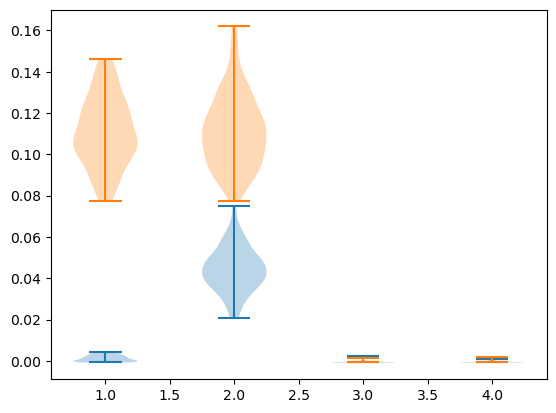

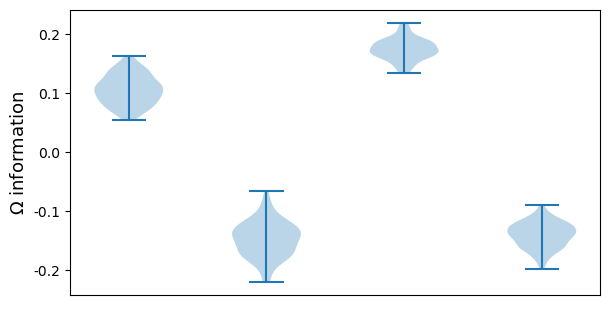

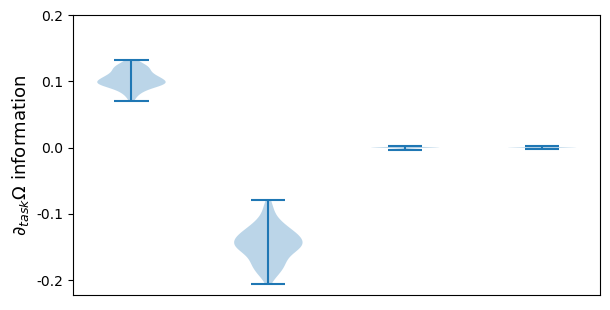

In [7]:
plt.violinplot([r123_syn, r456_syn, r789_syn, r101112_syn])
plt.violinplot([r123_red, r456_red, r789_red, r101112_red])
plt.show()
plt.close()

fontsize=13
plt.figure(figsize=(6,3))
plt.violinplot([oinfo123, oinfo456, oinfo101112, oinfo789])
plt.xticks([])
plt.yticks([-0.2,-0.1,0.0,0.1,0.2], [-0.2,-0.1,0.0,0.1,0.2])
plt.ylabel('$\Omega$ information', fontsize=fontsize)
plt.tight_layout(pad=0.35)
plt.savefig('oinfo_violin_plot', dpi=600)
plt.show()
plt.close()

plt.figure(figsize=(6,3))
plt.violinplot([oinfo_gradient123, oinfo_gradient456, oinfo_gradient789, oinfo_gradient101112])
plt.yticks([-0.2,-0.1,0.0,0.1,0.2], [-0.2,-0.1,0.0,0.1,0.2])
plt.xticks([])
plt.ylabel('$\partial_{task}\Omega$ information', fontsize=fontsize)
plt.tight_layout(pad=0.35)
plt.savefig('oinfo_gradient_violin_plot', dpi=600)
plt.show()
plt.close()



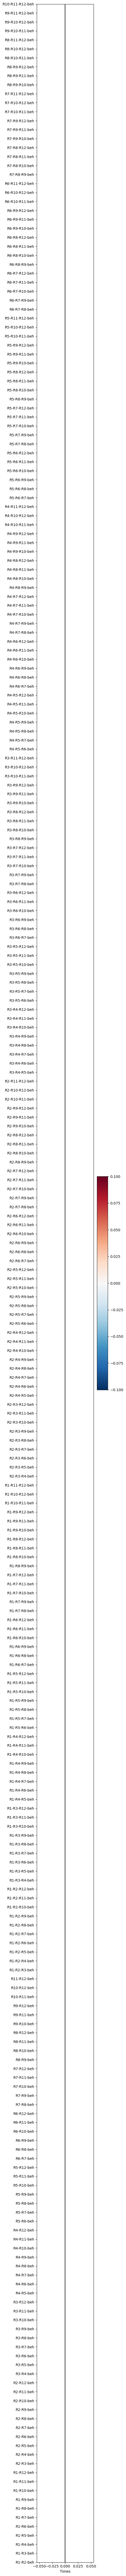

In [99]:
vmin, vmax = -0.1,0.1
minmax = max(abs(vmin), abs(vmax))
vmin, vmax = -minmax, minmax

# plot the results
df = oinfo.to_pandas()
plt.figure(figsize=(5,100))
plt.pcolormesh(
    df.columns, df.index, df.values, cmap='RdBu_r', vmin=vmin, vmax=vmax
)
plt.colorbar()
plt.xlabel('Times')
plt.axvline(0., color='k')

'''
redu = ['-'.join(roi[list(r)]) for r in redundancy]
syn = ['-'.join(roi[list(r)]) for r in synergy]
for n_k, k in enumerate(oinfo['roi'].data):
    if k.replace('-beh', '') in redu:
        plt.gca().get_yticklabels()[n_k].set_color('red')
    if k.replace('-beh', '') in syn:
        plt.gca().get_yticklabels()[n_k].set_color('blue')
'''
plt.tight_layout()
#plt.savefig('C:/Users/matte/OneDrive/Documenti/matteo/figure_simulations.png', dpi=600)
plt.show()
plt.close()

In [75]:
for roi_com in oinfo['roi'].data:
    for roi_sub_com in oinfo_without_beh['roi'].data:
        if roi_sub_com == roi_com[:-4]:
            oinfo.data[np.where(oinfo['roi'].data==roi_com)[0][0], :]=oinfo.sel(roi=roi_com)-oinfo_without_beh.sel(roi=roi_sub_com)
        

NameError: name 'oinfo_without_beh' is not defined

In [ ]:
vmin, vmax = -0.1,0.1
minmax = max(abs(vmin), abs(vmax))
vmin, vmax = -minmax, minmax

# plot the results
df = oinfo.to_pandas()
plt.figure(figsize=(5,100))
plt.pcolormesh(
    df.columns, df.index, df.values, cmap='RdBu_r', vmin=vmin, vmax=vmax
)
plt.colorbar()
plt.xlabel('Times')
plt.axvline(0., color='k')

'''
redu = ['-'.join(roi[list(r)]) for r in redundancy]
syn = ['-'.join(roi[list(r)]) for r in synergy]
for n_k, k in enumerate(oinfo['roi'].data):
    if k.replace('-beh', '') in redu:
        plt.gca().get_yticklabels()[n_k].set_color('red')
    if k.replace('-beh', '') in syn:
        plt.gca().get_yticklabels()[n_k].set_color('blue')
'''
plt.tight_layout()
#plt.savefig('C:/Users/matte/OneDrive/Documenti/matteo/figure_simulations.png', dpi=600)
plt.show()
plt.close()

In [254]:
oinfo.data[np.where(oinfo['roi'].data=='R5-R6-R11-R12-beh')[0][0], :]=np.where(np.abs(oinfo.sel(roi='R5-R6-R11-R12-beh')-oinfo.sel(roi='R5-R6-beh'))<0.001,0,oinfo.sel(roi='R4-R5-R11-beh'))

In [255]:
oinfo.sel(roi='R4-R5-R11-beh')

<xarray.DataArray 'Oinfo' (times: 200)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
    roi      <U18 'R4-R5-R11-beh'
  * times    (times) int32 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199
Attributes:
    sfreq:         1.0
    sources:       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 9, ...
    targets:       [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 3, 4, 5, 6, 7, 8, 1...
    task_related:  1
    minsize:       2
    maxsize:       4

In [92]:
for roi_com in oinfo['roi'].data:
    for roi_sub_com in oinfo['roi'].data:
        if set(roi_sub_com.split('-')) < set(roi_com.split('-')) and roi_sub_com != roi_com :
            #print('yes')
            oinfo.data[np.where(oinfo['roi'].data==roi_com)[0][0], :]=np.where(np.abs(oinfo.sel(roi=roi_com)-oinfo.sel(roi=roi_sub_com))<0.005,  oinfo.sel(roi=roi_com)-oinfo.sel(roi=roi_sub_com),  oinfo.sel(roi=roi_com))
            #print(roi_com, roi_sub_com)
            #print(oinfo.sel(roi=roi_com))

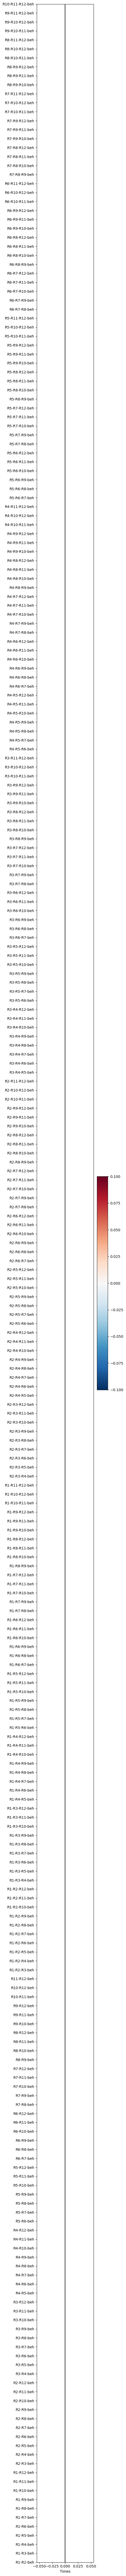

In [82]:
vmin, vmax = -0.1,0.1
minmax = max(abs(vmin), abs(vmax))
vmin, vmax = -minmax, minmax

# plot the results
df = oinfo.to_pandas()
plt.figure(figsize=(5,100))
plt.pcolormesh(
    df.columns, df.index, df.values, cmap='RdBu_r', vmin=vmin, vmax=vmax
)
plt.colorbar()
plt.xlabel('Times')
plt.axvline(0., color='k')

'''
redu = ['-'.join(roi[list(r)]) for r in redundancy]
syn = ['-'.join(roi[list(r)]) for r in synergy]
for n_k, k in enumerate(oinfo['roi'].data):
    if k.replace('-beh', '') in redu:
        plt.gca().get_yticklabels()[n_k].set_color('red')
    if k.replace('-beh', '') in syn:
        plt.gca().get_yticklabels()[n_k].set_color('blue')
'''
plt.tight_layout()
#plt.savefig('C:/Users/matte/OneDrive/Documenti/matteo/figure_simulations.png', dpi=600)
plt.show()
plt.close()

In [292]:
oinfo_dict=dict()
for i in range(len(oinfo['roi'].data)):
    oinfo_dict[oinfo['roi'].data[i][:-4].split('-')]=oinfo.sel(roi=roi_com)

TypeError: unhashable type: 'list'

In [468]:
xcolors

array([7.18435798e-01, 1.00000000e+00, 8.11959607e-01, 5.07646384e-01,
       2.56761854e-01, 1.54077059e-03, 2.42053473e-04, 1.81646740e-04,
       2.47728642e-03, 0.00000000e+00, 3.20257343e-04, 7.18435798e-01,
       7.18435798e-01, 5.07646384e-01, 2.56761854e-01, 1.54077059e-03,
       2.42053473e-04, 1.81646740e-04, 2.47728642e-03, 0.00000000e+00,
       3.20257343e-04, 8.11959607e-01, 5.07646384e-01, 2.56761854e-01,
       1.54077059e-03, 2.42053473e-04, 1.81646740e-04, 2.47728642e-03,
       0.00000000e+00, 3.20257343e-04, 5.07646384e-01, 2.56761854e-01,
       1.54077059e-03, 2.42053473e-04, 1.81646740e-04, 2.47728642e-03,
       0.00000000e+00, 3.20257343e-04, 2.56761854e-01, 1.54077059e-03,
       2.42053473e-04, 1.81646740e-04, 2.47728642e-03, 0.00000000e+00,
       3.20257343e-04, 1.54077059e-03, 2.42053473e-04, 1.81646740e-04,
       2.47728642e-03, 0.00000000e+00, 3.20257343e-04, 2.42053473e-04,
       1.81646740e-04, 1.54077059e-03, 0.00000000e+00, 3.20257343e-04,
      

Computation subject list 

0.07187795156174959 #ff2222
0.08353496908729108 #ff1818
-0.02421751179145737 #ff7272
-0.014301687516885764 #ff6a6a
-0.007720912015299675 #ff6464
0.03781168269801549 #ff3e3e
-0.015951972483049914 #ff6c6c
-0.009479744926467859 #ff6666
-0.02277152675522842 #ff7272
-0.0160196163651527 #ff6c6c
-0.014206768223383293 #ff6a6a
0.07185101913314584 #ff2222
-0.20582400993088212 #f4f4ff
-0.04915419281663347 #ff8888
0.11360400459756148 #ff0000
0.06396181756100061 #ff2828
0.06728955762228628 #ff2626
0.06916116628336466 #ff2424
0.07197884977847613 #ff2222
0.07184071890841581 #ff2222
0.07188094126389233 #ff2222
0.07184935125732173 #ff2222
0.07183509979653868 #ff2222
0.07189943208116789 #ff2222
0.06444952773894208 #ff2828
0.07121382259356679 #ff2222
0.07449314288424702 #ff2020
0.08363828313995292 #ff1818
0.08359637856449886 #ff1818
0.08353142810205405 #ff1818
0.08352584363284166 #ff1818
0.08361714333833703 #ff1818
0.08358965260245199 #ff1818
0.06210077945346937 #ff2a2a
-0.4259186501343617 #3a3aff
-0.023

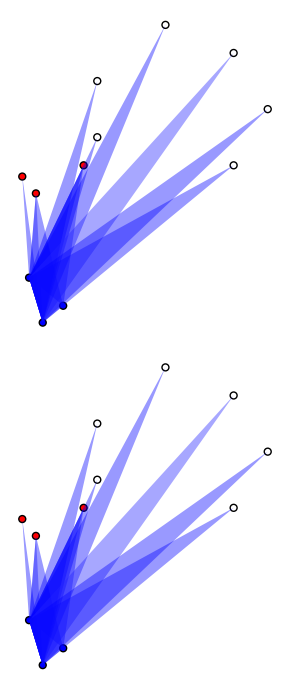

In [8]:
fig, ax= plt.subplots(2,1, figsize=(3,7))
for j, orientation in enumerate(['top', 'left']):

        
    axes=ax[j]
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.spines['left'].set_visible(False)
      
    with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
        im = f[orientation]['imp'][...]
        settings = {"min_node_size": 2.0,
        "max_node_size": 5.0,
        "min_dyad_lw": 2.0,
        "max_dyad_lw": 10.0,
        "min_node_lw": 1.0,
        "max_node_lw": 5.0,
        "node_fc_cmap": cm.Reds,
        "node_ec_cmap": cm.Greys,
        "edge_fc_cmap": cm.Blues,
        "dyad_color_cmap": cm.Greys}
        
                
        x_h={'R1':[260, 350],
            'R2':[240, 380],
            'R3':[330, 400],
            'R4':[270,120],
            'R5':[300,150],
            'R6':[250, 200],
            'R7':[350, 450],
            'R8':[350, 550],
            'R9':[550, 400],
            'R10':[450,650],
            'R11':[550,600],
            'R12':[600, 500]}
        
        xcolors=(oinfo.data[:,0]-min(oinfo.data[:,0]))/max(oinfo.data[:,0]-min(oinfo.data[:,0]))
        cmap=[]
        for i in range(len(oinfo.data[:,0])):
            if np.abs(oinfo.data[i,0].T)>0.005:
                cmap.append(matplotlib.colors.rgb2hex(cm.bwr((oinfo.data[:,0]))[i,:]))
                print(oinfo.data[i,0], matplotlib.colors.rgb2hex(cm.bwr((xcolors))[i,:]))
        
        #axes.imshow(im)
        axes.set_xticks([])
        axes.set_yticks([])
        
        #list_syn=[[int(i) for i in a[100].keys()[i].split('-')] for i in np.where(np.array(a[100])<-0.12)[0]]
        #list_red=[[int(i) for i in a[100].keys()[i].split('-')] for i in np.where(np.array(a[100])>0.12)[0]]
        #list_syn=[['R1','R2','R3'], ['R3','R4','R5'], ['R6'],['R7'],['R8'],['R9'],['R10'],['R11']]
        list_syn=[elem[:-4].split('-') for elem in oinfo['roi'].data if oinfo.sel(roi=elem)[0]<-0.1]
        #list_syn.append(['R10', 'R11', 'R12'])
        #list_syn.append(['R9', 'R11','R12'])
        print(list_syn)
        
        
        #list_red=[[int(i) for i in a[100].keys()[i].split('-')] for i in np.where(np.array(a[100])>0.12)[0]]
        syn_h=xgi.classes.hypergraph.Hypergraph()
        
        syn_h.add_nodes_from(['R1','R2','R3','R4','R5','R6','R7','R8','R9','R10','R11','R12'])
        syn_h.add_edges_from(list_syn)

        print(len(list_syn))
        print(list_syn)
        print(len(cmap))
        #red_h=xgi.classes.hypergraph.Hypergraph(list_red)
        #syn_h.add_weighted_edges_from([('R6','R7', 1),('R1','R3','R8', 1)])
        draw_xgi_nodes(syn_h, pos=x_h, ax=axes,
            node_fc=['red','red','red','blue','blue','blue','white','white','white','white','white','white'],
            node_ec="black",
            node_lw=1,
            node_size=5,
            zorder=1,
            settings=settings,
            max_order=1,
            node_labels=False)
        
        draw_xgi_hyperedges(syn_h, pos=x_h, ax=axes,
            dyad_color="white",
            dyad_lw=0,
            #edge_fc=['blue','red','red','red','red','red','red','red','black', 'green'],
            edge_fc=cmap,
            max_order=3,
            settings=settings,
            hyperedge_labels=False)
            
        '''ax=axes,dyad_color="black",
            dyad_lw=1.5,
            edge_fc=None,
            node_fc="white",
            node_ec="black",
            node_lw=1,
            node_size=15,
            max_order=None,
            node_labels=False,
            hyperedge_labels=False'''
        
        #if orientation =='left':
            #axes.scatter(*x_h.T, color='red', s=70*np.ones(len(x_h)), marker='.', alpha=1)
              
        #if orientation =='right':

            #if right_i != []:
                #axes.scatter(*x_h.T, color='red', s=70*np.ones(len(x_h)), marker='.', alpha=1)
                
        #if orientation =='top':
            #axes.scatter(*x_h.T, color='red', s=70*np.ones(len(x_h)), marker='.', alpha=1)

                
        #axes.title.set_text('engagement '+sound)
        

plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()
plt.savefig(path+'brain_plots_syn.png', dpi=600)

([], [])

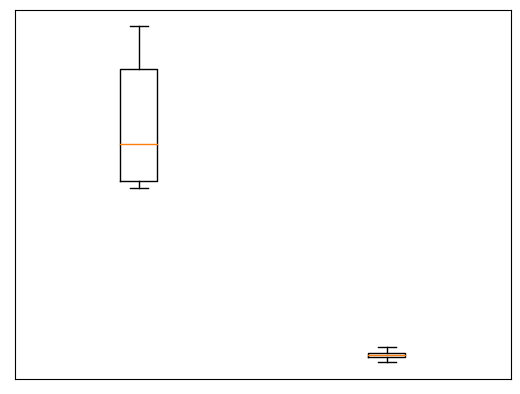

In [130]:
plt.boxplot(np.array([np.random.rand(10)*10+8, np.random.rand(10)]).T)
plt.xticks([])
plt.yticks([])

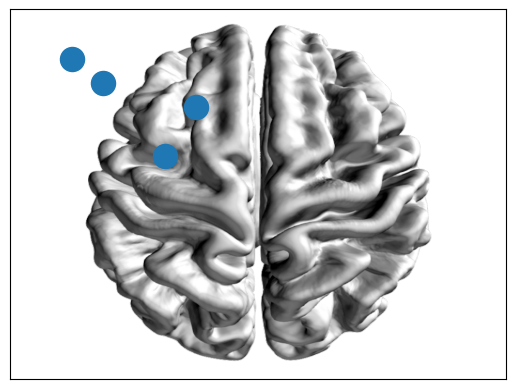

In [335]:

with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
    im = f['top']['imp'][...]
        
        
                
    x_h=np.array([[100,  100],
        [150, 150],
        [200, 200],
        [250,300],
        [300,200],
        [500, 250]])
        
            
    #plt.imshow(im, aspect='auto')
    #plt.show()
    #list_syn=[[int(i) for i in a[100].keys()[i].split('-')] for i in np.where(np.array(a[100])<-0.12)[0]]
    #list_red=[[int(i) for i in a[100].keys()[i].split('-')] for i in np.where(np.array(a[100])>0.12)[0]]
    list_syn=[[0,1,2], [3,4,5]]
    #list_red=[[int(i) for i in a[100].keys()[i].split('-')] for i in np.where(np.array(a[100])>0.12)[0]]
    #syn_h=xgi.classes.hypergraph.Hypergraph(list_syn)
    #red_h=xgi.classes.hypergraph.Hypergraph(list_red)
    #xgi.drawing.xgi_pylab.draw(syn_h, pos=x_h)

    # Create a new hypergraph
    G = nx.MultiDiGraph()

    # Add edges to the hypergraph
    G.add_edges_from(list_syn)

    # Plot the hypergraph
    plt.imshow(im, aspect='auto')
    nx.draw_networkx_nodes(G, pos=x_h)
    #nx.draw_networkx_edges(G)
    plt.show()
    #plt.tight_layout()
plt.show()
plt.close()
#plt.savefig(path+'figure/brain_plots_all_channels_peaks_std_99_percentile_major5_'+sound+'.png', dpi=600)

In [13]:

sound_list=['rest','music','speech']
arr_mu = os.listdir(path +'seeg_fif_data/music')
arr_rest = os.listdir(path +'seeg_fif_data/speech')
arr_speech = os.listdir(path +'seeg_fif_data/rest')

subject_set_mu=set()
subject_set_speech=set()
subject_set_rest=set()
ch_H_i={}

for st in arr_mu: 
    #print(st)
    subject_set_mu.add(st.partition('_')[0])
    #print(st.partition('_')[0])
    
for st in arr_speech:
    subject_set_speech.add(st.partition('_')[0])
    
for st in arr_rest:
    subject_set_rest.add(st.partition('_')[0])

subject_list=list(subject_set_mu.intersection(subject_set_speech,subject_set_rest))

#Here I create a set of the  all channels
total_channels_set=set()

for subject in subject_list:
    with h5py.File(pjoin(path +'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
        #print(f.keys())
        #print('chnames', f['chnames'].shape)
        
        chnames = f['chnames'][...].astype('U')
        total_channels_set.update(chnames)
    with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
        print(f.keys())
        print('outlier_chans', f['outlier_chans']['strict_bads_names'])

        bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
        #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

    ## Cleaning from artifacts
    #List of bad channels indices
    ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

    clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
    ch_H_i[subject]=[i for i, ch in enumerate(clean_chnames) if 'H' in ch]
        
#print(total_channels_set)


#Here I create a set of the H channels
ch_H=set()
for ch in total_channels_set:
    
    if "H" in ch:
        ch_H.add(ch)
        


#Here I create another set of channels        
ch_IM=set()
for ch in total_channels_set:
    
    if "IP" in ch:
        ch_IM.add(ch)
#print(ch_H)

subject_list.remove('sub-82e330f8aadd')



<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (42,), type "|S11">
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (33,), type "|S11">
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'other', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (16,), type "|S11">
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (33,), type "|S13">
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'other', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (36,), type "|S13">
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'oth

In [63]:
data={}
with h5py.File(pjoin(path +'seeg_data_h5py/sub-3ef8645f99c5_seeg_preproc.hdf5'), 'r') as f:
    data['music']=f['music'][...][:,:10000]
    data['speech']=f['speech'][...][:,:10000]
    data['rest']=f['rest'][...][:,:10000]
    
    

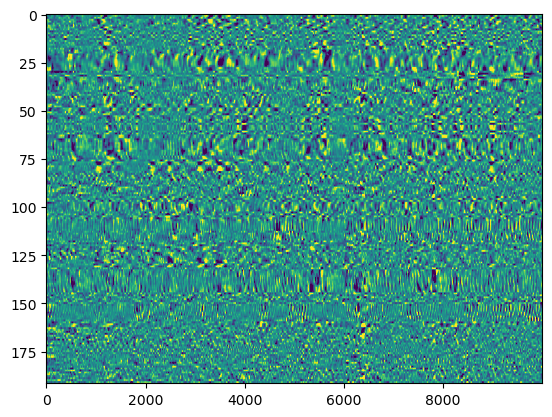

In [66]:
plt.imshow(scipy.stats.zscore(data['rest'], axis=1), aspect='auto', vmin=-2, vmax=2)
sv.saving(data, path + 'data_fufo_rawdata_sample500_all_conditions_sub-3ef8645f99c5_primi20sec_10_000')

In [15]:
ch_H_i

{'sub-e0bb6ccef2a5': [32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77],
 'sub-c2a96116ddc4': [87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
 'sub-45a6830d263e': [55, 56, 57, 58, 59, 60, 61, 62, 63],
 'sub-a4e7fc9daa96': [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61],
 'sub-28e70e7c7fbb': [9,
  10,
  11,
  12,
  13,
  14,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116],
 'sub-3ef8645f99c5': [88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
 'sub-aea837fa1826': [95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116],
 'sub-14c725b6b803': [29,
  30,
  31,
  32,
  33,
  34,
  35,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93],
 'sub-c1b7ce54ce05': [91, 92, 93, 94, 95, 96, 97, 98, 9

Firstly the indices of the time windows, where the dynamical inter-subjects correlation is higher then 99 percentile are computed.

In [9]:
window_length=50
time_interval=1
sound_list=['speech','music', 'rest']
dcorr_all=sv.loading(path+'dcorr_all_'+str(window_length)+'_'+str(time_interval))


ind_all={}

for sound in sound_list:
    
    corr_thres_l=np.percentile(dcorr_all[sound], 99)
    #corr_thres_h=np.percentile(dcorr_all[sound], 71)
    print(corr_thres_l)
    aa=set(np.where(dcorr_all[sound]>corr_thres_l)[0])
    #bb=set(np.where(dcorr_all[sound]<corr_thres_h)[0])
    print(len(aa))
    ind_all[sound]=list(aa)
    print(len(aa))
    #In the following line a different methdod per subject was studied
    """for subject in subject_list:
    
        corr_thres=np.percentile(dcorr[sound][subject], 99)

        ind[sound][subject]=np.where(dcorr[sound][subject]>corr_thres)[0]"""


0.0577219974493764
287
287
0.07664808867366665
289
289
0.03505523940293846
283
283


The indices of the time steps of the binarized dataset corresponding to the most correlated time windows (computed above), are computed in the following way. Below is for the moment when all subjects are particularly correlated between each others.

In [10]:
index_all=dict()
for sound in sound_list:
    
    aall=set()
    for i in ind_all[sound]:
        aall.update(np.arange(i,i+window_length))
            
    index_all[sound]=list(aall)

mem={}
m=min(len(index_all['speech']), len(index_all['music']))
print(len(index_all['speech']), len(index_all['music']), len(index_all['rest']))
for sound in ['speech', 'music', 'rest']:
    #index_all[sound]=index_all[sound][:m]
    mem[sound]=len(index_all[sound])


1184 783 1847


In [6]:
len(index_all['music'])

783

In [23]:
#loading the data ;)

datatipe='hgenv_down100'
data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 


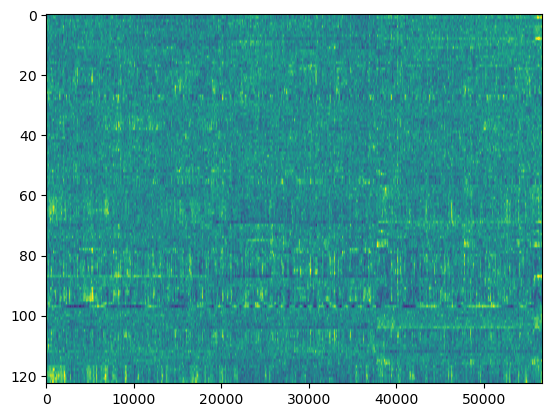

In [43]:
plt.imshow(scipy.stats.zscore(data[subject_list[17]]['rest'], axis=1), interpolation=None, aspect='auto', vmin=-1.2, vmax=1.2)

In [42]:
sv.saving(data[subject_list[17]]['rest'], path+ 'data_fufo_'+subject_list[17]+'_hactivity_down100')

In [20]:
data[subject_list[0]]['speech'].shape



(110, 57470)

Here we compute the null models for the engagement

In [21]:
datatipe='hgenv_down100'
data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

engagement_null=dict()

for isub, subject in enumerate(subject_list):
    print("computing for subject    ", subject)
    engagement_null[subject]=dict()
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    for sound in sound_list: 
        
        for i in np.arange(0,mem[sound],100):
            n_regions=len(zdata[sound])


            #avalanches dictionaries are computed using the functions of Utils_avalanches.py
            avalanches=av.go_avalanches(zdata[sound].T[i:,:], thre=thres, direc=0, binsize=2)
            n_time=len(avalanches['Zbin'].T[0,:])
            n_w=int(n_time/mem[sound])

            zdata_reshaped=np.reshape(avalanches['Zbin'].T[:,:n_time-(n_time%mem[sound])], [n_regions, mem[sound], int(n_time/mem[sound])])
            if i==0:

                engagement_null[subject][sound]=np.sum(zdata_reshaped, axis=1)

            else:
                engagement_null[subject][sound]=np.concatenate((engagement_null[subject][sound],np.sum(zdata_reshaped, axis=1)), axis=1)



computing for subject     sub-e0bb6ccef2a5
computing for subject     sub-c2a96116ddc4
computing for subject     sub-45a6830d263e
computing for subject     sub-a4e7fc9daa96
computing for subject     sub-28e70e7c7fbb
computing for subject     sub-3ef8645f99c5
computing for subject     sub-aea837fa1826


KeyboardInterrupt: 

(array([100., 283., 295., 122., 733., 126., 687., 260.,  80., 158.]),
 array([ 5. ,  6.5,  8. ,  9.5, 11. , 12.5, 14. , 15.5, 17. , 18.5, 20. ]),
 <BarContainer object of 10 artists>)

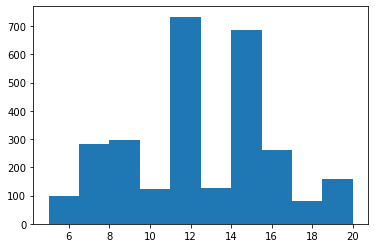

In [15]:
plt.hist(engagement_null[subject_list[3]]['music'][100])

In [7]:
datatipe='hgenv_down100'
engagement={}
data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    engagement[subject]={}
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
    for sound in ['speech', 'music']:
        engagement[subject][sound]={}
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        aval=avalanches['Zbin'][index_all[sound],:]
        engag=np.sum(aval, axis=0)
        engagement[subject][sound]['p_value']=[]
        engagement[subject][sound]['std']=[]
        for i, engr in enumerate(engag):
            engagement[subject][sound]['p_value'].append(len(np.where(engagement_null[subject][sound][i,:]>engr)[0])/len(engagement_null[subject][sound][i,:]))
            engagement[subject][sound]['std'].append((engr-np.mean(engagement_null[subject][sound][i,:]))/np.std(engagement_null[subject][sound][i,:]))
            
        engagement[subject][sound]['p_value']=np.array(engagement[subject][sound]['p_value'])
        engagement[subject][sound]['std']=np.array(engagement[subject][sound]['std'])
        
"""        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
           
    
    engagement_null=np.array(engagement_null)
    plt.hist(engagement_null[0])
    plt.show()
    plt.close()
    engagement_null_mean['speech'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['speech'][subject]=np.std(engagement_null, axis=0)
    
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        
        indices=random.sample(range(len(avalanches['Zbin'])), mem['music'])
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['music'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['music'][subject]=np.std(engagement_null, axis=0)
    
sv.saving(engagement_null_mean, path+'engagement_null_mean_9495')
sv.saving(engagement_null_std, path+'engagement_null_std_9495')

    

    #speech null model
    avalanches=av.go_avalanches(zdata['speech'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['speech'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['speech'][subject]=np.std(engagement_null, axis=0)
    
    
    #music null model
    avalanches=av.go_avalanches(zdata['music'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['music'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['music'][subject]=np.std(engagement_null, axis=0)
    
""" 



2.8552720483703933


NameError: name 'engagement_null' is not defined

In [8]:
enga={}
for sound in ['speech','music']:
    enga[sound]={}
    eng_total=engagement[subject_list[0]][sound]['std']
    for subject in subject_list[1:]:
        np.concatenate((eng_total,engagement[subject][sound]['std']))
    
    #thres_std=np.percentile(eng_total, 99)
    for subject in subject_list:
        pvalue=0.05
        thres_std=max(np.percentile(engagement[subject][sound]['std'],98),5)
        enga[sound][subject]=np.where(engagement[subject][sound]['std']>thres_std,1,0)
        print(subject, len(np.where(engagement[subject][sound]['std']>thres_std)[0]))
        

KeyError: 'sub-14c725b6b803'

KeyError: 'sub-fccb4adbfadc'

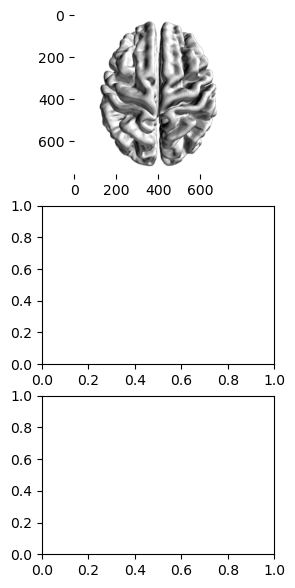

In [10]:
for o, sound in enumerate(['speech','music']):
    fig, ax= plt.subplots(3,1, figsize=(3,7))
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        
        for isub,subject in enumerate(subject_list):            
           
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
            
            print()
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                """if orientation == 'left':
                    cmap=[]
                    for i in range(len(engagement[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(engagement[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject][right_i]))[i,:]))"""
                
                    
                    
            elif orientation == 'top':
                """cmap=[]
                for i in range(len(engagement[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject]))[i,:]))"""
                x_h = coordinates
                
                
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color='red', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject][left_i]))
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color='red', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject][right_i]))
                
            if orientation =='top':
                axes.scatter(*x_h.T, color='red', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject]))

                
            #axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])

    plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    plt.savefig(path+'figure/brain_plots_all_channels_peaks_std_99_percentile_major5_'+sound+'.png', dpi=600)


In [16]:
with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
    coordinates=f['mayavi'][orientation]['xy'][...]
            
print(coordinates)
coordinates=coordinates[ch_i]

[[486.1185417  348.16033153]
 [499.16201039 347.71420369]
 [511.98847779 347.66171142]
 [525.2829809  347.67254935]
 [539.28787341 347.56459522]
 [553.52376075 347.67194627]
 [567.09378518 347.65982234]
 [580.5454553  347.58527594]
 [594.27227771 347.69292923]
 [317.08521585 299.85281533]
 [303.62273418 301.09312922]
 [289.75862353 302.21862158]
 [275.42785818 303.20103731]
 [260.7743628  304.47444157]
 [245.85289248 305.6657378 ]
 [231.74567266 307.04749104]
 [218.09876826 308.60501201]
 [351.78656502 233.83540282]
 [348.27435899 226.19122477]
 [344.69016453 218.31318457]
 [341.04708579 210.34329519]
 [331.6966872  190.95622028]
 [321.57176436 171.26716963]
 [317.188988   162.86524047]
 [312.82252925 154.3555397 ]
 [308.44350326 145.69944706]
 [297.21056355 124.31258649]
 [284.83440602 101.53418881]
 [279.80405255  91.5301633 ]
 [317.11508605 358.67728618]
 [302.65434335 359.30811418]
 [287.82550021 360.04881555]
 [273.2633991  360.86285767]
 [259.15745114 361.70878619]
 [245.22325255

In [12]:
datatipe='hgenv_down100'
channels={}
eng_simple={}
data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    channels[subject]={}
    eng_simple[subject]={}
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
    for sound in sound_list:
        with h5py.File(pjoin(path+'seeg_data_hgenv_down100_h5py/', subject + '_down100_seeg_preproc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('music', f['music'].shape)

            #data_music[subject]=f['music'][...]
            data_raw=f[sound][...]
            
            #Here we delete the time point of the rest that correspond to the end and beginning of the three sessions
            if sound=='rest':
                index_del=np.concatenate((np.arange(int(len(data_raw[0,:])/3)-200,int(len(data_raw[0,:])/3)+200),np.arange(int(len(data_raw[0,:])*2/3)-200,int(len(data_raw[0,:])*2/3)+200)))   
                data_raw=np.delete(data_raw, index_del, axis=1)

            data_raw=data_raw[:,100:-100]

        #Here we load the channels names
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
            print(f.keys())
            print('chnames', f['chnames'].shape)

            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            print(f.keys())
            print('outlier_chans', f['outlier_chans']['strict_bads_names'])

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
            #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

        ## Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]

        clean= np.delete(data_raw, ch_i, axis=0)

        #List of indices of H channels, list of indices of not H channels
        channels[subject]['H']= [i for i, ch in enumerate(clean_chnames) if 'H' in ch]
        ch_H_w_i= [i for i, ch in enumerate(clean_chnames) if 'H' not in ch]

        #HERE WE CREATE THE DATA SET, THAT WE USE
        #only the channels in Helsch gyrus
        clean_H = np.delete(clean, ch_H_i[subject], axis=0)

        #only the channels not in the helsch gyrus
        clean_without_H = np.delete(clean, ch_H_w_i, axis=0)

        #clean_mu=clean2(clean_music_H, N=3)
        #clean_sp=clean2(clean_speech_H, N=3)
        #clean_re=clean2(clean_rest_H, N=3)

        #zscore of the data
        zdata_art=stats.zscore(clean, axis=1)

        #the artifacts are substituted by 0
        zdata_=np.where(np.abs(zdata_art)>5, 0, zdata_art)

        #zscored computed again
        zdata=stats.zscore(zdata_, axis=1)
        avalanches=av.go_avalanches(zdata.T, thre=thres, direc=0, binsize=2)
        aval=avalanches['Zbin'][index_all[sound],:]
        eng_simple[subject][sound]=scipy.stats.zscore(np.sum(aval, axis=0))





    

    

NameError: name 'subject_list' is not defined

In [11]:
fs=12
engag={}        
for subject in subject_list:
    engag[subject]=[]
    for sound in sound_list:
        engag[subject].append(np.mean(eng_simple[subject][sound][ch_H_i[subject]]))
        

plt.figure(figsize=(4,3))
for subject in subject_list:
    plt.plot([np.mean(eng_simple[subject]['rest'][ch_H_i[subject]])/mem['rest'],np.mean(eng_simple[subject]['music'][ch_H_i[subject]])/mem['music'],np.mean(eng_simple[subject]['speech'][ch_H_i[subject]])/mem['speech']])
plt.xticks([0,1,2], sound_list, fontsize=fs)
#plt.ylabel('H norm AE', fontsize=fs)
#plt.tight_layout()
plt.savefig(path+'figure/h_engagement_subjects_lines.png', dpi=600)
plt.show()
plt.close()

engag_boxplot=np.zeros((3,19))

for i, sound in enumerate(sound_list):
    for j, subject in enumerate(subject_list):
        engag_boxplot[i,j]=engag[subject][i]

plt.figure(figsize=(4,3))
plt.boxplot(list(engag_boxplot), labels=sound_list)
#plt.legend(fontsize=fs)
#plt.ylabel('H norm AE', fontsize=fs)
#plt.tight_layout()
plt.savefig(path+'figure/h_engagement_boxplot.png', dpi=600)
plt.show()
plt.close()  

import seaborn as sns 
import pandas as pd

df = pd.DataFrame(engag_boxplot, columns=['normalized_engagement']*19, index=sound_list)
#sns.kdeplot(data=df, y='normalized_engagement', fill=True,  alpha=.5, linewidth=0)
from statsmodels.graphics.boxplots import violinplot

fig, ax = plt.subplots()
violinplot(data=df.values, ax=ax, labels=sound_list, side='right', show_boxplot=False)
fig.autofmt_xdate()



NameError: name 'subject_list' is not defined

In the following part I performed a statistical test to confirm the fact that during speech and music listening the study of the engagement of H allows to perfectly distinguish between different conditions

In [115]:
#between speech and rest

real_diff=np.mean(engag_boxplot[1])-np.mean(engag_boxplot[0])
count=0
test_boxplot=np.concatenate((engag_boxplot[0], engag_boxplot[1]))

for i in range(100000):
    aa=np.array(random.sample(list(test_boxplot),19))
    bb=np.array([i for i in test_boxplot if i not in aa])
    diff=np.mean(aa)-np.mean(bb)
    if diff>real_diff:
        count +=1

    

In [116]:
count/100000

0.00059

## trough studies, not correlated instant of time 

Here we study those moment when correlation is not highe 

In [241]:

datatipe='hgenv_down100'
engagement={}
enga_null={}

data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)

    engagement_nu=[]
    
    for i in np.arange(0, len(avalanches['Zbin'])-50,1):
        aval=avalanches['Zbin'][i:i+50, :]
        engagement_nu.append(np.sum(aval, axis=0)/50)
        
    enga_null[subject]=np.array(engagement_nu)



2.818625307029934
2.7331326834817284
2.7507264122036497
2.9744978125454247
2.750861898649132
2.803148765547773
2.734310175019014
2.897258743666651
2.78534246404477
3.334984151824247
2.8089245753814596
2.7761437719778965
2.8552720483703933
2.7654285000333187
2.79738475441734
2.774284818922206
2.7742837529435107
2.8138171563785437
2.7985919037396925


In [140]:

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)
    
    
    #speech null model
    avalanches=av.go_avalanches(zdata['speech'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['speech'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['speech'][subject]=np.std(engagement_null, axis=0)
    
    
    #music null model
    avalanches=av.go_avalanches(zdata['music'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['music'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['music'][subject]=np.std(engagement_null, axis=0)
    
    
for sound in ['music', 'speech']:
    
    engagement[sound]={}    
    engagementr[sound]={}
    meta_engagement[sound]={}
    
    for subject in subject_list:
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index_all[sound],:]
        print(min(np.sum(aval, axis=1)))
                                                           
        engagementt=np.sum(aval, axis=0)

        engagement[sound][subject]=(engagementt-engagement_null_mean[subject])/engagement_null_std[subject]
        
        meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
           
        engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        print(engagement[sound][subject])
        
sv.saving(engagement, path+'engagement_troughs')
sv.saving(meta_engagement, path+'meta_engagement_troughs' )


2.7761437719778965
2.9744978125454247


KeyboardInterrupt: 

In [242]:
enga_null[subject_list[0]].shape



(566, 150)

In [243]:

engagement={}

for sound in ['music', 'speech']:
    
    engagement[sound]={}    
    
    for subject in subject_list:
        print(subject)
        zdata=data[subject]  #loading the data of the three conditions that we saved before 
        
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
            #print(f.keys())
            #print('chnames', f['chnames'].shape)
            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
            #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

        ## Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
            #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)     
        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index_all[sound],:]
                                                               
        engagementt=np.sum(aval, axis=0)/mem[sound]
        
        sum_enga_null=np.sum(enga_null[subject], axis=1)
        
        print(np.sum(engagementt))
        
        aa=set(np.where(sum_enga_null>np.sum(engagementt)-0.1)[0])

        bb=set(np.where(sum_enga_null<np.sum(engagementt)+0.2)[0])
        
        print(len(aa.intersection(bb)))
        
        mean_null=np.mean(enga_null[subject][list(aa.intersection(bb)),:], axis=0)
        
        enn=[]
        for i in range(len(engagementt)):
            aaa=len(np.where(enga_null[subject][list(aa.intersection(bb)),i]>engagementt[i])[0])
            bbb=len(np.where(enga_null[subject][list(aa.intersection(bb)),i]<engagementt[i])[0])
            enn.append(aaa/(bbb+1))
            #plt.title(clean_chnames[i])
            #plt.hist(enga_null[subject][list(aa.intersection(bb)),:][i])
            #plt.axvline(engagementt[i])
            #plt.show()
            #plt.close()
            
        engagement[sound][subject]=np.array(enn)
        
        #std_null=np.std(enga_null[subject][list(aa.intersection(bb)), :], axis=0)
        
        #engagement[sound][subject]=(engagementt-mean_null)/std_null
        
        #meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
           
        #engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        #print(engagement[sound][subject])
        
sv.saving(engagement, path+'engagement_peaks_same_sum')
#sv.saving(meta_engagement, path+'meta_engagement_peaks' )

sub-3ef8645f99c5
2.818625307029934
(28918, 150)
2.3228066146072575
66
sub-95a634be7e05
2.7331326834817284
(28918, 151)
2.392397795130914
109
sub-14c725b6b803
2.7507264122036497
(28918, 168)
2.638033991731741
115
sub-aea837fa1826
2.9744978125454247
(28918, 167)
2.5312356453835556
61
sub-ebf231d97f73
2.750861898649132
(28918, 146)
2.303858520900322
101
sub-28e70e7c7fbb
2.803148765547773
(28918, 117)
1.8155718879191547
121
sub-cacae171ee15
2.734310175019014
(28918, 116)
1.7624023886081766
131
sub-44375d501493
2.897258743666651
(28918, 157)
2.451998162609095
114
sub-e0bb6ccef2a5
2.78534246404477
(28918, 110)
1.6995865870463942
157
sub-82e330f8aadd
3.334984151824247
(28918, 147)
2.3720716582452916
6
sub-83ebd5328120
2.8089245753814596
(28918, 121)
1.8870004593477263
105
sub-4247d6d6cdbf
2.7761437719778965
(28918, 108)
1.726228755167662
109
sub-fccb4adbfadc
2.8552720483703933
(28918, 109)
1.698897565457051
111
sub-9d783b836f5e
2.7654285000333187
(28918, 123)
2.0527101515847495
93
sub-26176ef

In [2]:
abb=[]
app=[]

for k in [0.1]:
    count2=0
    count=0

    for i in range(18):
        print(len(np.where(np.array(engagement['speech'][subject_list[i]])<k)[0]))
        count+=len(np.where(np.array(engagement['speech'][subject_list[i]])<k)[0])
        count2+=len(np.where(np.array(engagement['speech'][subject_list[i]])<k)[0])
    abb.append(count)
    app.append(count2)

print(count)
plt.plot(abb)
plt.plot(app)

NameError: name 'np' is not defined

Analisi, facciamo variare le soglie di correlazione massima e minima e vediamo che succede alle regioni significative. Vogliamo far vedere che nei momenti in cui i soggetti sono molto correlati ci sono cose in h e regioni di interesse

In [50]:
datatipe='hgenv_down100'
engagement={}
enga_null={}

data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)

    engagement_nu=[]
    
    for i in np.arange(0, len(avalanches['Zbin'])-50,1):
        aval=avalanches['Zbin'][i:i+50, :]
        engagement_nu.append(np.sum(aval, axis=0)/50)
        
    enga_null[subject]=np.array(engagement_nu)


engagement={}

window_length=50
time_interval=1

dcorr_all=sv.loading(path+'dcorr_all_'+str(window_length)+'_'+str(time_interval))

for per in np.arange(0,100, 9)[1:]:

    ind_all={}
    engagement[per]={}
    
    for sound in sound_list:
    
        corr_thres_l=np.percentile(dcorr_all[sound], per)
        corr_thres_h=np.percentile(dcorr_all[sound], per+1)
        print(corr_thres_l, corr_thres_h)
        aa=set(np.where(dcorr_all[sound]>corr_thres_l)[0])
        bb=set(np.where(dcorr_all[sound]<=corr_thres_h)[0])
        print(len(aa), len(bb))
        ind_all[sound]=list(aa)
        print(len(aa.intersection(bb)))
    
    index_all=dict()
    for sound in sound_list:
    
        aall=set()
        for i in ind_all[sound]:
            aall.update(np.arange(i,i+window_length))
            
        index_all[sound]=list(aall)

    mem={}
    m=min(len(index_all['speech']), len(index_all['music']))
    print(len(index_all['speech']), len(index_all['music']), len(index_all['rest']))
    for sound in ['speech', 'music', 'rest']:
        #index_all[sound]=index_all[sound][:m]
        mem[sound]=len(index_all[sound])
    
    for sound in ['music', 'speech']:
    
        engagement[per][sound]={}    

        for subject in subject_list:
            print(subject)
            zdata=data[subject]  #loading the data of the three conditions that we saved before 

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

                #print(f.keys())
                #print('chnames', f['chnames'].shape)
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']

            #Here we load the list of bad channels
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
                #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
                #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

            ## Cleaning from artifacts
            #List of bad channels indices
            ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

            clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
                #the threshold is derived as the 99th percentile of the data
            thres=np.percentile(zdata['rest'], 99)
            print(thres)     

            #avalanches dictionaries are computed using the functions of Utils_avalanches.py
            avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)

            print(avalanches['Zbin'].shape)
            aval=avalanches['Zbin'][index_all[sound],:]

            engagementt=np.sum(aval, axis=0)/mem[sound]

            sum_enga_null=np.sum(enga_null[subject], axis=1)

            print(np.sum(engagementt))

            aa=set(np.where(sum_enga_null>np.sum(engagementt)-0.1)[0])

            bb=set(np.where(sum_enga_null<np.sum(engagementt)+0.1)[0])

            print(len(aa.intersection(bb)))

            mean_null=np.mean(enga_null[subject], axis=0)

            enn=[]
            for i in range(len(engagementt)):
                aaa=len(np.where(enga_null[subject][:,i]>engagementt[i])[0])
                bbb=len(np.where(enga_null[subject][:,i]<engagementt[i])[0])
                enn.append(aaa/(bbb+1))
                #plt.title(clean_chnames[i])
                #plt.hist(enga_null[subject][list(aa.intersection(bb)),:][i])
                #plt.axvline(engagementt[i])
                #plt.show()
                #plt.close()

            engagement[per][sound][subject]=np.array(enn)

            #std_null=np.std(enga_null[subject][list(aa.intersection(bb)), :], axis=0)

            #engagement[sound][subject]=(engagementt-mean_null)/std_null

            #meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]

            #engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))

            #print(engagement[sound][subject])

sv.saving(engagement, path+'engagement_percentile1__99_asound_asubject')

2.7507264122036497
2.7742837529435107
2.734310175019014
2.818625307029934
2.8089245753814596
2.7761437719778965
2.803148765547773
2.774284818922206
2.7654285000333187
2.79738475441734
2.9744978125454247
2.8138171563785437
2.78534246404477
2.7985919037396925
3.334984151824247
2.897258743666651
2.750861898649132
2.8552720483703933
2.7331326834817284
-0.016053813196017917 -0.015461240314665111
25739 2829
283
-0.013092963009911024 -0.012525597649224382
26269 2887
288
-0.01323864600553319 -0.012521295700879398
26103 2869
287
28685 28874 28294
sub-14c725b6b803
2.7507264122036497
(28918, 168)
2.6320911546720236
3684
sub-a4e7fc9daa96
2.7742837529435107
(28918, 115)
1.801863267991965
2437
sub-cacae171ee15
2.734310175019014
(28918, 116)
1.7712821223245825
4946
sub-3ef8645f99c5
2.818625307029934
(28918, 150)
2.2236267922698616
2270
sub-83ebd5328120
2.8089245753814596
(28918, 121)
1.886922490822193
3718
sub-4247d6d6cdbf
2.7761437719778965
(28918, 108)
1.6951582738796147
4524
sub-28e70e7c7fbb
2.803

(28735, 117)
1.769454623841345
4771
sub-c1b7ce54ce05
2.774284818922206
(28735, 135)
2.0253287346410866
2744
sub-9d783b836f5e
2.7654285000333187
(28735, 123)
1.9753179564561327
3688
sub-26176ef8a8d0
2.79738475441734
(28735, 86)
1.340482862685924
4057
sub-aea837fa1826
2.9744978125454247
(28735, 167)
2.3585542861248827
2132
sub-45a6830d263e
2.8138171563785437
(28735, 107)
1.5666091830135802
3670
sub-e0bb6ccef2a5
2.78534246404477
(28735, 110)
1.706258532729755
5371
sub-c2a96116ddc4
2.7985919037396925
(28735, 139)
2.1875763454767547
3517
sub-82e330f8aadd
3.334984151824247
(28735, 147)
2.3454049004814257
366
sub-44375d501493
2.897258743666651
(28735, 157)
2.4431630380110656
4100
sub-ebf231d97f73
2.750861898649132
(28735, 146)
2.1768700150894587
3733
sub-fccb4adbfadc
2.8552720483703933
(28735, 109)
1.671768340878063
3795
sub-95a634be7e05
2.7331326834817284
(28735, 151)
2.417403175971833
3457
-0.0055726531611229885 -0.005266205737888638
18102 10466
283
-0.00166818508949638 -0.00132483840183299

KeyboardInterrupt: 

preplotting 

In [49]:
engagement[99]['music']

{'sub-14c725b6b803': array([0.68149646, 0.30023456, 0.73953975, 0.81947484, 0.82146769,
        0.31670625, 0.60366442, 0.61770428, 0.95877503, 1.1824147 ,
        0.96572104, 0.68149646, 0.29315708, 0.86853933, 0.76165254,
        1.06840796, 0.42015371, 0.53413284, 0.76914894, 0.80173348,
        0.74684874, 0.60521236, 0.77481323, 0.32721468, 0.77481323,
        0.59596929, 0.55565949, 0.24104478, 0.6208577 , 0.43362069,
        0.87485908, 0.89840183, 0.33574297, 1.17670157, 0.82346491,
        0.77481323, 0.54553903, 0.77292111, 0.72510373, 0.73048907,
        0.76165254, 0.76914894, 0.27043545, 0.24943651, 0.96804734,
        1.22326203, 0.84777778, 0.69693878, 0.87274775, 0.69175992,
        0.8664422 , 0.28615623, 0.82948295, 1.08135169, 0.35644372,
        0.91810842, 0.67472306, 0.63520157, 0.44232437, 0.91810842,
        0.45749343, 0.43115318, 0.31462451, 0.62561095, 0.34221146,
        0.3509342 , 0.30944882, 0.78817204, 1.02311436, 0.82346491,
        1.09974747, 0.353132

In [43]:
enga={}
for per in np.arange(0,100,9)[1:]:
    print(per)
    enga[per]={}
    for sound in ['speech','music']:
        enga[per][sound]={}
        for subject in subject_list:
            pvalue=0.05
            if pvalue > min(engagement[per][sound][subject]):
                print('')
                print('yes')
            enga[per][sound][subject]=np.where(engagement[per][sound][subject]<pvalue,1,0)


9

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
18

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
27

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
36

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
45

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
54

yes

yes

yes

yes

yes

yes

yes

yes

yes
63

yes

yes

yes

yes

yes

yes

yes

yes
72

yes

yes

yes

yes

yes

yes

yes

yes
81

yes

yes

yes

yes

yes

yes

yes

yes
90

yes

yes

yes

yes

yes

yes

yes

yes

yes
99

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes


plotting

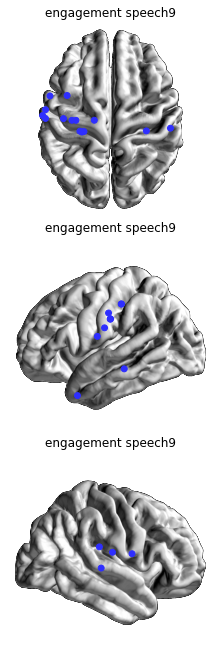

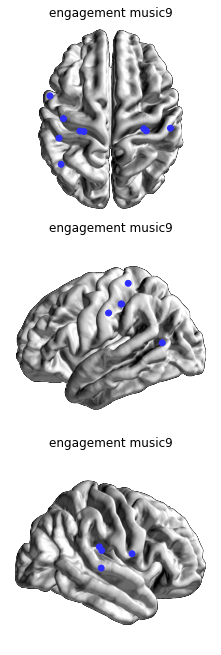

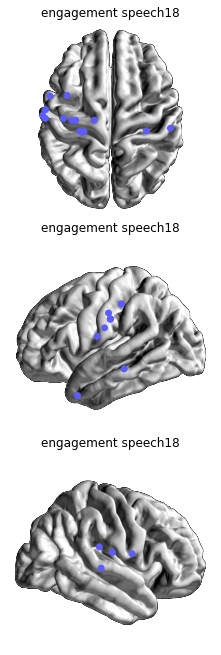

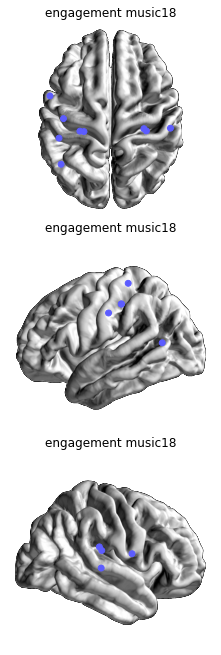

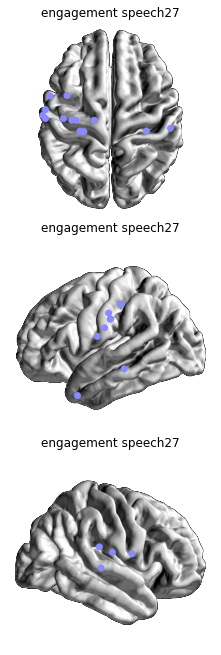

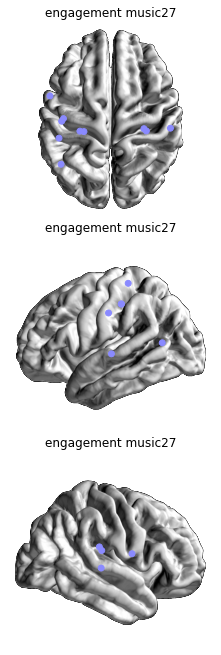

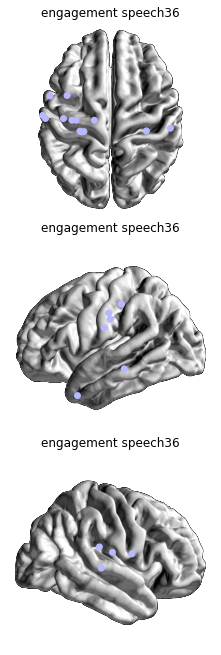

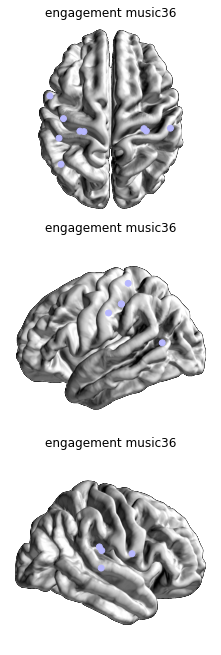

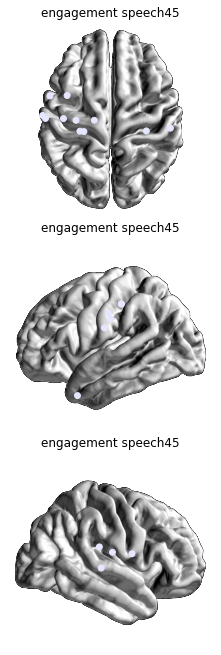

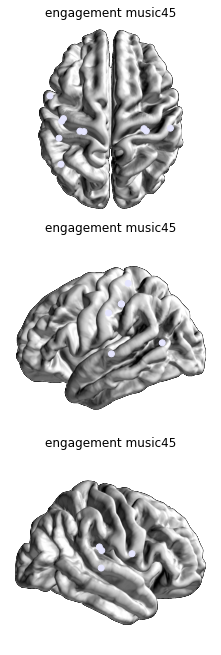

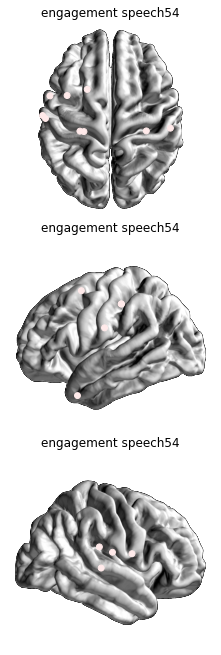

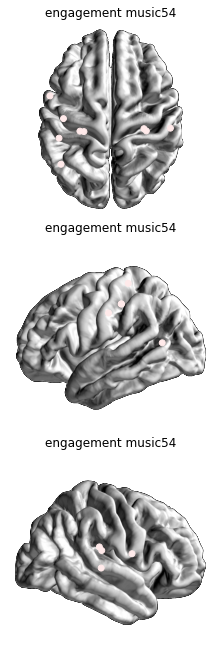

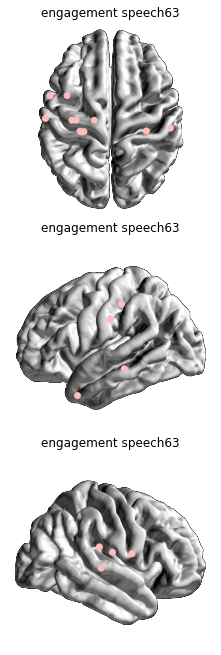

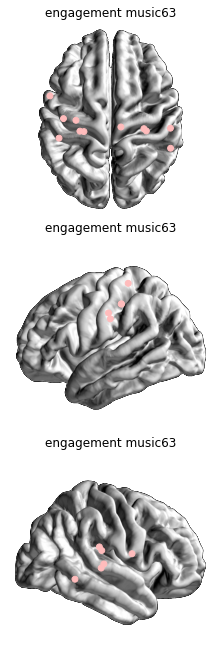

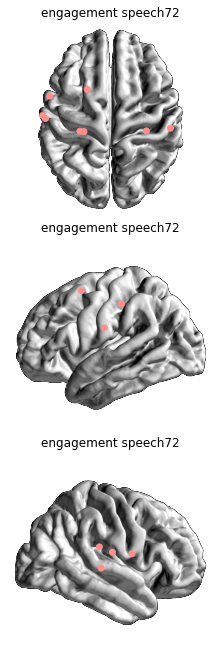

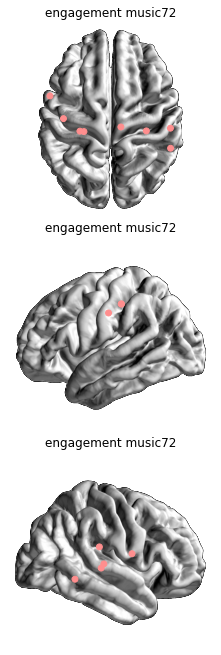

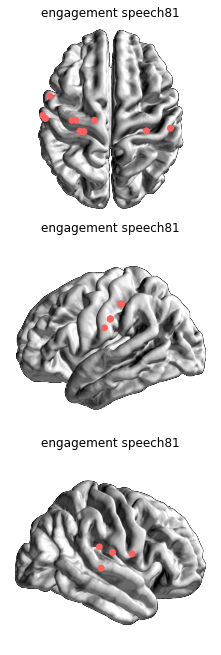

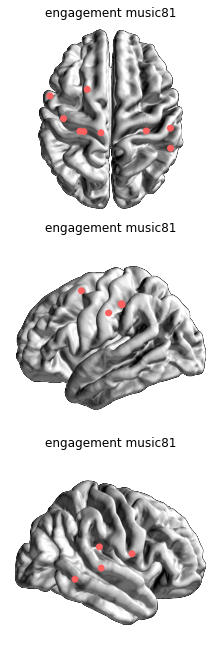

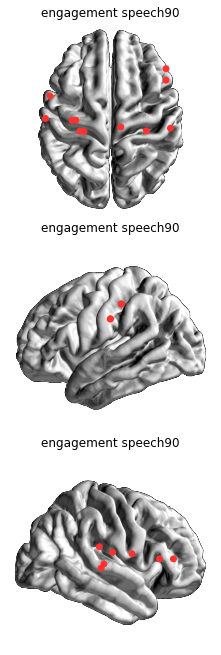

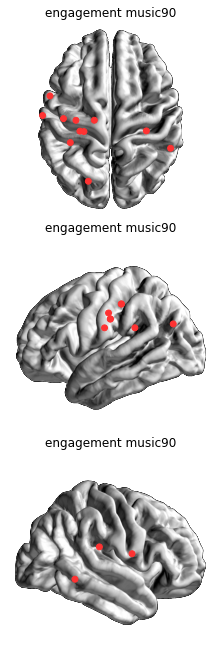

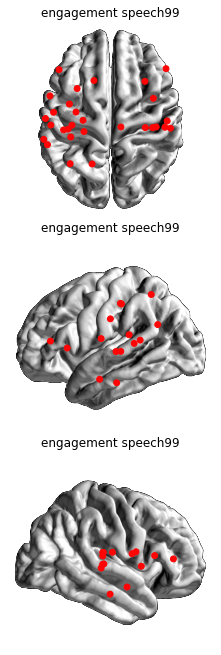

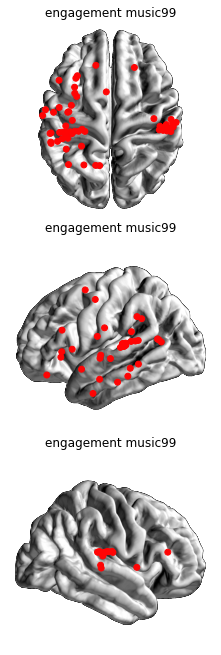

In [44]:

'''
#plotting
plt.figure(figsize=(3,1.7))
for subject in subject_list:
    plt.plot(mean_eng[subject])
plt.title('eng H - all subjects')
plt.xticks([0,1,2], ['speech','music','rest'], fontsize=10)
plt.ylabel('mean eng', fontsize=10)
plt.tight_layout()
plt.savefig(path+'figure/'+ 'engament of H - across conditions - all subjects', dpi=600)
plt.show()
plt.close()'''

for per in np.arange(0,100,9)[1:]:
    
    for o, sound in enumerate(['speech','music']):
        
        fig, ax= plt.subplots(3,1, figsize=(3,9))
        
        for j, orientation in enumerate(['top','left','right']):


            axes=ax[j]
            axes.spines['top'].set_visible(False)
            axes.spines['right'].set_visible(False)
            axes.spines['bottom'].set_visible(False)
            axes.spines['left'].set_visible(False)

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:

                im = f[orientation]['imp'][...]

            for isub,subject in enumerate(subject_list[:-1]):            

                with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                    #print(f.keys())
                    #print('chnames', f['chnames'].shape)

                    chnames = f['chnames'][...].astype('U')
                    x=f['chlocs']


                with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                    #print(f.keys())
                    #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

                    bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

                ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]

                chnames=chnames[ch_i]

                # collect coordinates for this specific orientation (only one patient)
                with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

                    coordinates=f['mayavi'][orientation]['xy'][...]

                coordinates=coordinates[ch_i]

                # make sure you only select the left electrodes for the left orientation and
                # right electrodes for the right orientation


                if orientation in ('left', 'right'):

                    _, _, left_i, right_i = mp.split_hemis(chnames)
                    x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]

                    if orientation == 'left':
                        cmap=[]
                        for i in range(len(engagement[per][sound][subject][left_i])):
                            cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[per][sound][subject][left_i]))[i,:]))

                    if orientation == 'right':
                        cmap=[]
                        for i in range(len(engagement[per][sound][subject][right_i])):
                            cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[per][sound][subject][right_i]))[i,:]))



                elif orientation == 'top':
                    cmap=[]
                    for i in range(len(engagement[per][sound][subject])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[per][sound][subject]))[i,:]))
                    x_h = coordinates


                axes.imshow(im)
                if orientation =='left':
                    if left_i != []:
                        axes.scatter(*x_h.T, color=cm.bwr(per/100), s=35*np.ones(len(x_h)), marker='o', alpha=(enga[per][sound][subject][left_i]))

                if orientation =='right':

                    if right_i != []:
                        axes.scatter(*x_h.T, color=cm.bwr(per/100), s=35*np.ones(len(x_h)), marker='o', alpha=(enga[per][sound][subject][right_i]))

                if orientation =='top':
                    axes.scatter(*x_h.T, color=cm.bwr(per/100), s=35*np.ones(len(x_h)), marker='o', alpha=(enga[per][sound][subject]))


                axes.title.set_text('engagement '+sound+str(per))
                axes.set_xticks([])
                axes.set_yticks([])

        plt.tight_layout(pad=0.35)
        plt.savefig(path+'figure/brain_plots_all_channels_thres6std_9495'+sound+str(per)+'.png', dpi=600)


Analisi proposta da Fufo, contare quante volte durante tutto il tempo le mie regioni si allontanano da quello che spiegherebbe il rest. Io qua lo faccio comparando finestre di taglia simile.

In [46]:
datatipe='hgenv_down100'

enga_null={}

data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)

    engagement_nu=[]
    
    for i in np.arange(0, len(avalanches['Zbin'])-50,1):
        aval=avalanches['Zbin'][i:i+50, :]
        engagement_nu.append(np.sum(aval, axis=0)/50)
        
    enga_null[subject]=np.array(engagement_nu)


temporal_engagement={}

for sound in ['music', 'speech']:
    
    temporal_engagement[sound]={}    

    for subject in subject_list:
        print(subject)
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

            #print(f.keys())               #print('chnames', f['chnames'].shape)
            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
            #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

        ## Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)     

        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)

        print(avalanches['Zbin'].shape)
        
        enga_list=[]
        for winb in range(len(avalanches['Zbin'])-50):
            
            aval=avalanches['Zbin'][winb:winb+50,:]

            engagementt=np.sum(aval, axis=0)/50

            sum_enga_null=np.sum(enga_null[subject], axis=1)

            #print(np.sum(engagementt))

            aa=set(np.where(sum_enga_null>np.sum(engagementt)-0.1)[0])

            bb=set(np.where(sum_enga_null<np.sum(engagementt)+0.15)[0])

            #print(len(aa.intersection(bb)))

            mean_null=np.mean(enga_null[subject][list(aa.intersection(bb)),:], axis=0)

            enn=[]
            for i in range(len(engagementt)):
                aaa=len(np.where(enga_null[subject][list(aa.intersection(bb)),i]>engagementt[i])[0])
                bbb=len(np.where(enga_null[subject][list(aa.intersection(bb)),i]<engagementt[i])[0])
                enn.append(aaa/(bbb+1))
                
            enga_list.append(enn)
            
        temporal_engagement[sound][subject]=np.array(enga_list)

            #std_null=np.std(enga_null[subject][list(aa.intersection(bb)), :], axis=0)

            #engagement[sound][subject]=(engagementt-mean_null)/std_null

            #meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]

            #engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))

            #print(engagement[sound][subject])

#sv.saving(engagement, path+'engagement_percentile1__99_asound_asubject')

2.7507264122036497
2.7742837529435107
2.734310175019014
2.818625307029934
2.8089245753814596
2.7761437719778965
2.803148765547773
2.774284818922206
2.7654285000333187
2.79738475441734
2.9744978125454247
2.8138171563785437
2.78534246404477
2.7985919037396925
3.334984151824247
2.897258743666651
2.750861898649132
2.8552720483703933
2.7331326834817284
sub-14c725b6b803
2.7507264122036497
(28918, 168)


KeyboardInterrupt: 

In [33]:
engagement[9]['speech']

{'sub-14c725b6b803': array([0.75996016, 0.80122324, 0.81977343, 0.88983957, 0.91960891,
        0.64678472, 1.07151231, 0.68929254, 0.81603289, 0.74691053,
        0.70313253, 0.67092199, 0.79847328, 0.88178914, 0.76965448,
        0.82919255, 0.67092199, 0.57697456, 0.79390863, 0.80122324,
        0.78214826, 0.63990719, 1.00681431, 0.9248366 , 0.77320622,
        0.69903846, 0.64448581, 0.67965779, 0.68125595, 0.83489097,
        0.80952381, 0.26712083, 0.69010043, 0.97430168, 0.75996016,
        0.74260355, 0.56371681, 0.96442468, 0.78846154, 0.56164384,
        0.74260355, 0.91752577, 0.2461213 , 0.31816486, 0.85123101,
        0.87579618, 0.73065622, 0.58831461, 0.77498744, 0.86589229,
        0.70889749, 0.88379531, 0.27904452, 0.94282573, 0.88279169,
        0.70559846, 0.75558867, 0.26440072, 0.79027356, 0.75996016,
        0.73405299, 0.26575931, 0.35366479, 0.38969721, 0.3957346 ,
        0.31816486, 0.31326644, 0.73150416, 0.73150416, 0.75037147,
        0.95033113, 0.933260

In [38]:
cm.bwr(0.2)

(0.4, 0.4, 1.0, 1.0)

In [14]:
np.arange(0,37,9)

array([ 0,  9, 18, 27, 36])

In [15]:
engagement[2]['speech']

KeyError: 2

Here we compute the engagement

In [169]:
engagement_null_std=sv.loading(path + 'engagement_null_std_9495')
engagement_null_mean=sv.loading(path + 'engagement_null_mean_9495')


engagement={}
for sound in ['music', 'speech']:
    
    engagement[sound]={}    
    meta_engagement[sound]={}
    
    for subject in subject_list:
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        print(sound, len(index_all[sound]))
        aval=avalanches['Zbin'][index_all[sound],:]
        print(min(np.sum(aval, axis=1)))
                                                           
        engagementt=np.sum(aval, axis=0)
        engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
        
        #meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
           
        #engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        #print(engagement[sound][subject])
        
sv.saving(engagement, path+'engagement_peaks_9495')
#sv.saving(meta_engagement, path+'meta_engagement_peaks' )



2.818625307029934
(28918, 150)
music 783
0
2.7331326834817284
(28918, 151)
music 783
0
2.7507264122036497
(28918, 168)
music 783
0
2.9744978125454247
(28918, 167)
music 783
0
2.750861898649132
(28918, 146)
music 783
0
2.803148765547773
(28918, 117)
music 783
0
2.734310175019014
(28918, 116)
music 783
0
2.897258743666651
(28918, 157)
music 783
0
2.78534246404477
(28918, 110)
music 783
0
3.334984151824247
(28918, 147)
music 783
0
2.8089245753814596
(28918, 121)
music 783
0
2.7761437719778965
(28918, 108)
music 783
0
2.8552720483703933
(28918, 109)
music 783
0
2.7654285000333187
(28918, 123)
music 783
0
2.79738475441734
(28918, 86)
music 783
0
2.774284818922206
(28918, 135)
music 783
0
2.7742837529435107
(28918, 115)
music 783
0
2.8138171563785437
(28918, 107)
music 783
0
2.7985919037396925
(28918, 139)
music 783
0
2.818625307029934
(28735, 150)
speech 1184
0
2.7331326834817284
(28735, 151)
speech 1184
0
2.7507264122036497
(28735, 168)
speech 1184
0
2.9744978125454247
(28735, 167)
speech 

In [10]:
datatipe='hgenv_down100'
data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

eng_simple={}

for sound in sound_list:
    
    eng_simple[sound]={}
    
    for subject in subject_list:
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        #print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        #print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index_all[sound],:]
        #print(min(np.sum(aval, axis=1)))
                                                           
        engagementt=np.sum(aval, axis=0)/mem[sound]
        eng_simple[sound][subject]=stats.zscore(engagementt)
        
        #print(engagement[sound][subject])
        
sv.saving(eng_simple, path+'engagement_peaks_simple')


In [11]:
mem

{'speech': 1184, 'music': 783, 'rest': 1847}

{'rest': {'sub-3ef8645f99c5': array([0.01840823, 0.01245263, 0.01786681, 0.01136979, 0.01136979,
         0.02436383, 0.01407688, 0.01353546, 0.01732539, 0.01028695,
         0.02273958, 0.02003249, 0.01407688, 0.01353546, 0.02003249,
         0.00974553, 0.01515972, 0.01353546, 0.01570114, 0.01515972,
         0.01732539, 0.01245263, 0.01515972, 0.01732539, 0.01245263,
         0.01894965, 0.01624256, 0.0205739 , 0.01299404, 0.01353546,
         0.01732539, 0.01082837, 0.01299404, 0.01028695, 0.01299404,
         0.01245263, 0.01299404, 0.01732539, 0.02003249, 0.01299404,
         0.01082837, 0.01191121, 0.01678397, 0.01028695, 0.01407688,
         0.01570114, 0.01570114, 0.02165674, 0.01949107, 0.02652951,
         0.0086627 , 0.01678397, 0.02003249, 0.00920411, 0.0146183 ,
         0.00487277, 0.02652951, 0.01570114, 0.01732539, 0.01678397,
         0.01949107, 0.01515972, 0.01515972, 0.01840823, 0.0146183 ,
         0.01082837, 0.01570114, 0.00974553, 0.01353546, 0.00974553,
      

In [30]:
len(subject_list)

19

In the followig code we put a threshold on the engagement as what define the max meta_engagemnt for both the condition of music and speech.

In [43]:
#engagement=sv.loading(path+'engagement_peaks')
#=sv.loading( path+'meta_engagement_peaks')


enga={}
for sound in ['speech','music', 'rest']:
    enga[sound]={}
    for subject in subject_list:
        #eng_simple[sound][subject]=stats.zscore(eng_simple[sound][subject])
        thress=3
        #thress=np.percentile(eng_simple[sound][subject], 99)
        print(thress, max(eng_simple[sound][subject]))
        if thress < max(eng_simple[sound][subject]):
            print('')
            print('yes')
        enga[sound][subject]=np.where(eng_simple[sound][subject]>thress,1,0)


3 2.9992545150100556
3 3.752013234281613

yes
3 3.6176761602152148

yes
3 4.119858173617509

yes
3 4.455147636830109

yes
3 2.877438046599236
3 3.9008100268662487

yes
3 4.5346995473985094

yes
3 3.8809400275627817

yes
3 4.633452247372878

yes
3 3.9184588997172516

yes
3 3.7572323590068524

yes
3 5.9559605066095225

yes
3 3.372863823646096

yes
3 3.3884296961708604

yes
3 3.171084339185992

yes
3 6.120148808244589

yes
3 3.068646092736573

yes
3 3.56221353838315

yes
3 5.0115826626843045

yes
3 2.879083189427651
3 4.190354155905132

yes
3 5.507878919267851

yes
3 5.17148345952359

yes
3 4.069292295344024

yes
3 5.847723370798193

yes
3 2.6553980095143985
3 4.412626719001906

yes
3 5.801331670181939

yes
3 5.0995362876838755

yes
3 3.479695697934964

yes
3 3.2161971500228477

yes
3 3.2009324980101215

yes
3 6.196154890356634

yes
3 2.6233957218764705
3 4.286260857660729

yes
3 3.377654298546309

yes
3 4.420706138315865

yes
3 4.352758047103878

yes
3 3.9752062314125682

yes
3 2.4131124

In [42]:

import numpy as np

arr = np.array([1, 2, 3, 4, 5, 6])

print('Original array: ', arr)

np.random.shuffle(arr)

print('Shuffle',np.random.shuffle(arr))

Original array:  [1 2 3 4 5 6]
Shuffle None


Finally the brain plot 

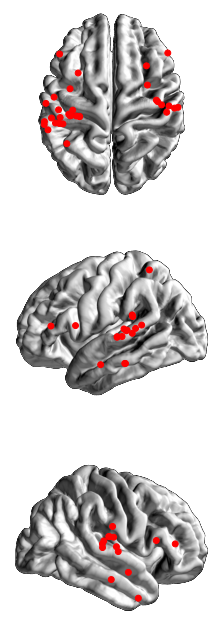

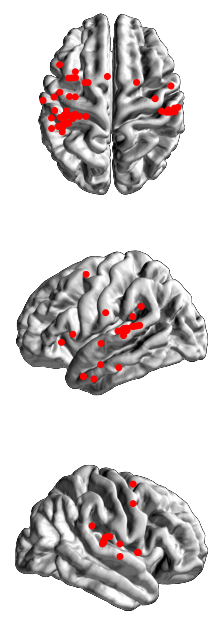

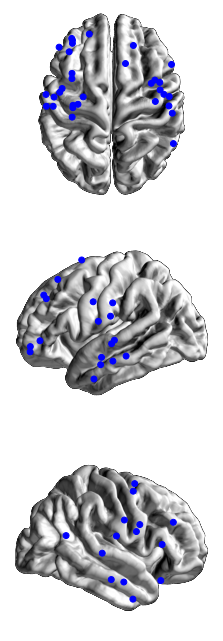

In [44]:

'''
#plotting
plt.figure(figsize=(3,1.7))
for subject in subject_list:
    plt.plot(mean_eng[subject])
plt.title('eng H - all subjects')
plt.xticks([0,1,2], ['speech','music','rest'], fontsize=10)
plt.ylabel('mean eng', fontsize=10)
plt.tight_layout()
plt.savefig(path+'figure/'+ 'engament of H - across conditions - all subjects', dpi=600)
plt.show()
plt.close()'''


        
for o, sound in enumerate(['speech','music', 'rest']):
    fig, ax= plt.subplots(3,1, figsize=(3,9))
    if sound=='rest':
        colors='blue'
    else:
        colors='red'
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        for isub,subject in enumerate(subject_list):            
           
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
                
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                if orientation == 'left':
                    cmap=[]
                    for i in range(len(eng_simple[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((eng_simple[sound][subject][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(eng_simple[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((eng_simple[sound][subject][right_i]))[i,:]))
                
                    
                    
            elif orientation == 'top':
                cmap=[]
                for i in range(len(eng_simple[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((eng_simple[sound][subject]))[i,:]))
                x_h = coordinates
                
                
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color=colors, s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject][left_i]))
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color=colors, s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject][right_i]))
                
            if orientation =='top':
                axes.scatter(*x_h.T, color=colors, s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject]))

                
            #axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])
    
    plt.tight_layout(pad=0.35)
    plt.savefig(path+'figure/brain_plots_all_channels_thres6std_zscoring_AE'+sound+'.png', dpi=600)


In [51]:
for o, sound in enumerate(['speech','music', 'rest']):
    for isub,subject in enumerate(subject_list[:-16]):            
           
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            print(f['atlasses'].keys())
            print(f['atlasses']['Brainnetome'][...][0][:5])

            
            #print('chnames', f['chnames'].shape)
            

<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'STG, '
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'Hipp,'
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'FuG, '
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'STG, '
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'Hipp,'
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainne

# The code for figure 3 - the study of troughs

Here we repeat the exact procedure as before, selecting not the most correlated windows of time but the worst correlated ones.

In [138]:
ind={}
ind_all={}

for sound in sound_list:
    
    ind[sound]={}
    corr_thres=np.percentile(dcorr_all[sound], 1)
    ind_all[sound]=np.where(dcorr_all[sound]<corr_thres)[0]
   
    """for subject in subject_list:
    
        corr_thres=np.percentile(dcorr[sound][subject], 1)

        ind[sound][subject]=np.where(dcorr[sound][subject]<corr_thres)[0]"""


Computation of the time indices corresponding to the time windows in which the inter-subject correlation is lower.

In [139]:
index_all=dict()
for sound in sound_list:
    
    aall=set()
    for i in ind_all[sound]:
        aall.update(np.arange(i,i+window_length))
            
    index_all[sound]=list(aall)

m=min(len(index_all['speech']), len(index_all['music']))
print(len(index_all['speech']), len(index_all['music']))
for sound in ['speech', 'music']:
    index_all[sound]=index_all[sound][:m]
    


1755 2672


The null models for all the conditions. This procedure as a not indifferent computational cost. Because of that we save the results in the end. 

In [140]:
n_iterations=1000

engagement={}
engagementr={}

meta_engagement={}
engagement_null_mean={}
engagement_null_std={}
engagement_null_mean['speech']={}
engagement_null_std['speech']={}
engagement_null_mean['music']={}
engagement_null_std['music']={}
data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)
    
    
    #speech null model
    avalanches=av.go_avalanches(zdata['speech'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['speech'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['speech'][subject]=np.std(engagement_null, axis=0)
    
    
    #music null model
    avalanches=av.go_avalanches(zdata['music'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['music'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['music'][subject]=np.std(engagement_null, axis=0)
    
    
for sound in ['music', 'speech']:
    
    engagement[sound]={}    
    engagementr[sound]={}
    meta_engagement[sound]={}
    
    for subject in subject_list:
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index_all[sound],:]
        print(min(np.sum(aval, axis=1)))
                                                           
        engagementt=np.sum(aval, axis=0)

        engagement[sound][subject]=(engagementt-engagement_null_mean[subject])/engagement_null_std[subject]
        
        meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
           
        engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        print(engagement[sound][subject])
        
sv.saving(engagement, path+'engagement_troughs')
sv.saving(meta_engagement, path+'meta_engagement_troughs' )


2.7761437719778965
2.9744978125454247


KeyboardInterrupt: 

Here we threshold the engagement in the 2 different methods.A 'yes' is printed in the terminal each time a subject has some channels with an engagement higher then the threshold.

In [144]:
engagement=sv.loading( path+'engagement_troughs')
meta_engagement=sv.loading( path+'meta_engagement_troughs')

enga={}
for sound in ['speech','music']:
    enga[sound]={}
    for subject in subject_list:
        #thress=5
        thress=max(meta_engagement[sound][subject])
        print(thress, max(engagement[sound][subject]))
        if thress < max(engagement[sound][subject]):
            print('')
            print('yes')
        enga[sound][subject]=np.where(engagement[sound][subject]>thress,1,0)


3.7998929169443563 4.134790647162713

yes
5.586756477841421 4.718148669486915
3.897957868655255 3.9713051055071427

yes
3.79678378374912 4.364133123841681

yes
4.3559974375713475 3.407174767793895
3.645544515507889 6.665640415257806

yes
2.643907478921373 3.268139541907688

yes
3.2608735562391455 3.9652057131760623

yes
4.614030478292361 3.965508714305009
4.766757084314771 6.18522862302905

yes
4.820578801577677 3.3296571352172126
5.7010461188813855 6.019540189847105

yes
7.443818483509169 8.816905795007951

yes
3.771900333146485 4.086600947927816

yes
3.9202847831292638 4.033433175681596

yes
5.2039261368737115 6.516833680353489

yes
3.737692338974128 3.4092575386420267
4.783188250946411 5.03632352093113

yes
3.334623673923427 3.1870984320073794
5.708112798665167 5.136790149186428
4.466470850333907 10.18090042297443

yes
4.561096763715792 4.623685095650037

yes
3.71740478894777 4.34218587341388

yes
3.9112376853890187 3.7253402711755044
5.664487334830701 5.457437808822177
2.6790683052

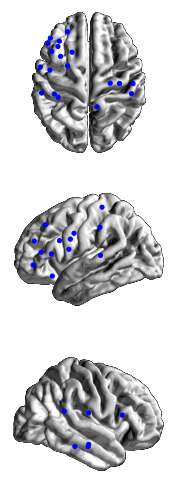

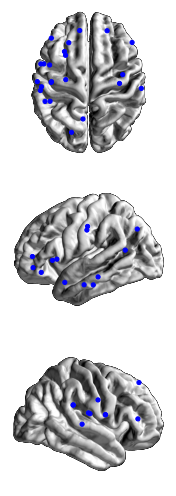

In [147]:

'''
#plotting
plt.figure(figsize=(3,1.7))
for subject in subject_list:
    plt.plot(mean_eng[subject])
plt.title('eng H - all subjects')
plt.xticks([0,1,2], ['speech','music','rest'], fontsize=10)
plt.ylabel('mean eng', fontsize=10)
plt.tight_layout()
plt.savefig(path+'figure/'+ 'engament of H - across conditions - all subjects', dpi=600)
plt.show()
plt.close()'''


        
for o, sound in enumerate(['speech','music']):
    fig, ax= plt.subplots(3,1, figsize=(3,7))
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        
        for isub,subject in enumerate(subject_list):            
           
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
                
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                if orientation == 'left':
                    cmap=[]
                    for i in range(len(engagement[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(engagement[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject][right_i]))[i,:]))
                
                    
                    
            elif orientation == 'top':
                cmap=[]
                for i in range(len(engagement[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject]))[i,:]))
                x_h = coordinates
                
                
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color='blue', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject][left_i]))
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color='blue', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject][right_i]))
                
            if orientation =='top':
                axes.scatter(*x_h.T, color='blue', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject]))

                
            #axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])

    plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    plt.savefig(path+'figure/brain_plots_all_channels_troughs_maxmetasound_'+sound+'.png', dpi=600)


## Engagement of Helsch Gyrus, is it changing across conditions in the most inter-subject correlated window of time?

In this part we are interested in the study of the engagement of the Helsch gyrus. 



In [124]:
ch_H_i=sv.loading(path+'H_channels_indices_subjects')

In [125]:
eng_simple=sv.loading(path+'engagement_peaks_simple')    

In [126]:
sound_list

['rest', 'music', 'speech']

Plotting

In [66]:


fs=12
engag={}        
for subject in subject_list:
    engag[subject]=[]
    for sound in sound_list:
        engag[subject].append(np.mean(eng_simple[sound][subject][ch_H_i[subject]]))
        

plt.figure(figsize=(4,3))
for subject in subject_list:
    plt.plot([np.mean(eng_simple['rest'][subject][ch_H_i[subject]]),np.mean(eng_simple['music'][subject][ch_H_i[subject]]),np.mean(eng_simple['speech'][subject][ch_H_i[subject]])])
plt.xticks([0,1,2], sound_list, fontsize=fs)
#plt.ylabel('H norm AE', fontsize=fs)
#plt.tight_layout()
plt.savefig(path+'figure/h_engagement_subjects_lines.png', dpi=600)
plt.show()
plt.close()

engag_boxplot=np.zeros((3,19))

for i, sound in enumerate(sound_list):
    for j, subject in enumerate(subject_list):
        engag_boxplot[i,j]=engag[subject][i]

plt.figure(figsize=(4,3))
plt.boxplot(list(engag_boxplot), labels=sound_list)
#plt.legend(fontsize=fs)
#plt.ylabel('H norm AE', fontsize=fs)
#plt.tight_layout()
plt.savefig(path+'figure/h_engagement_boxplot.png', dpi=600)
plt.show()
plt.close()  



    

    

NameError: name 'subject_list' is not defined

pvalue computation

In [137]:
ent_random_=np.concatenate((engag_boxplot[0,:], engag_boxplot[2,:]))

real_differ=np.mean(engag_boxplot[2,:])-np.mean(engag_boxplot[0,:])
list_random_corr=[]
count=0
n_it=100000
for i in range(n_it):
    indices=random.sample(range(38), 19)
    ent_random1=ent_random_[indices]
    indices=random.sample(range(38), 19)
    ent_random2=ent_random_[indices]
    differ=np.mean(ent_random1)-np.mean(ent_random2)
    list_random_corr.append(differ)
    if differ>real_differ:
        count+=1

pvalue=count/n_it

if pvalue==0:
    print('for speech vs rest, pvalue <', 1/n_it)
else:
    print('for speech vs rest, pvalue =', pvalue)

ent_random_=np.concatenate((engag_boxplot[0,:], engag_boxplot[1,:]))

real_differ=np.mean(engag_boxplot[1,:])-np.mean(engag_boxplot[0,:])
list_random_corr=[]
count=0
n_it=100000
for i in range(n_it):
    indices=random.sample(range(38), 19)
    ent_random1=ent_random_[indices]
    indices=random.sample(range(38), 19)
    ent_random2=ent_random_[indices]
    differ=np.mean(ent_random1)-np.mean(ent_random2)
    list_random_corr.append(differ)
    if differ>real_differ:
        count+=1

pvalue=count/n_it        
if pvalue==0:
    print('for music vs rest, pvalue <', 1/n_it)
else:
    print('for music vs rest, pvalue =', pvalue)

    

for speech vs rest, pvalue < 1e-05
for music vs rest, pvalue < 1e-05


## VARIOUS ANALYSIS....

In the following part we are going to study the correlation between the dynamical correlation in time window and the engagement in time windows.

1 THE ENGAGEMENT IN TIME WINDOW

In [206]:
n_iterations=400

engagement_null_mean={}
engagement_null_std={}

data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), 200)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)


2.7507264122036497
2.8138171563785437
2.7654285000333187
3.334984151824247
2.7761437719778965
2.9744978125454247
2.774284818922206
2.7985919037396925
2.734310175019014
2.803148765547773
2.8552720483703933
2.78534246404477
2.7331326834817284
2.897258743666651
2.79738475441734
2.750861898649132
2.8089245753814596
2.818625307029934
2.7742837529435107


In [225]:
window_length=50
time_interval=1
d_engagement={}

for sound in ['speech','music']:
    d_engagement[sound]={}
    
    for subject in subject_list:
        zdata=data[subject][sound]
        thres=np.percentile(data[subject]['rest'], 99)
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata.T, thre=thres, direc=0, binsize=2)
        aval=avalanches['Zbin'].T
        t_length=len(aval[0,:])
        n_w=len(np.arange(0, t_length - window_length, time_interval))
        d_engagement[sound][subject]=np.zeros((len(aval),n_w))
        
        print(d_engagement[sound][subject].shape)
        windows=np.arange(0, t_length- window_length, time_interval)
        for i in range(n_w):
            t_start=windows[i]
            d_engagement[sound][subject][:,i] =(np.sum(aval[:,t_start:t_start+window_length], axis=1)-engagement_null_mean[subject])/engagement_null_std[subject]
            
            
            
            
            


(168, 143)
(107, 143)
(123, 143)
(147, 143)
(108, 143)
(167, 143)
(135, 143)
(139, 143)
(116, 143)
(117, 143)
(109, 143)
(110, 143)
(151, 143)
(157, 143)
(86, 143)
(146, 143)
(121, 143)
(150, 143)
(115, 143)
(168, 144)
(107, 144)
(123, 144)
(147, 144)
(108, 144)
(167, 144)
(135, 144)
(139, 144)
(116, 144)
(117, 144)
(109, 144)
(110, 144)
(151, 144)
(157, 144)
(86, 144)
(146, 144)
(121, 144)
(150, 144)
(115, 144)


In [212]:
len(np.arange(0, - window_length, time_interval))

143

In [215]:
(len(aval[0,:])-window_length)/time_interval


142.675

In [222]:


#computations
for sound in sound_list:
    dcorr[sound]={}
    dcorr_matrix[sound]=[]
    mat=[]
    
    for isub, subject in enumerate(subject_list):
        dcorr[sound][subject]=[]
        
        for i in np.arange(0,len(rss_matrix[sound][0,:])-window_length, time_interval):
            dcorr[sound][subject].append(np.sum((np.corrcoef(rss_matrix[sound][:,i:i+window_length])-np.identity(19))[isub,:])/18)
        
        #print(len(dcorr[sound][subject]))
        mat.append(dcorr[sound][subject])
        
    dcorr_matrix[sound]=np.array(mat)
    dcorr_all[sound]=np.mean(np.array(mat), axis=0)
    print('la lunghezza è', dcorr_matrix[sound].shape)

la lunghezza è (19, 141)
la lunghezza è (19, 144)
la lunghezza è (19, 143)


In [229]:
ch_H_i


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114]

The results of this computation

In [173]:
d_engagement['speech'][subject]=np.array(d_engagement['speech'][subject])

In [165]:
final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in ch_H_i]
        final_channels_all[subject]final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in ch_H_i]
        final_channels_all[subject]

(57787, 115)

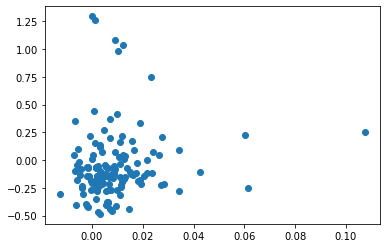

In [237]:
plt.plot(dcorr_all['speech'], np.mean(d_engagement['speech'][subject_list[8]], axis=0), 'o')

In [250]:
sr={}
pval={}
for sound in ['speech', 'music']:
    sr[sound]={}
    pval[sound]={}
    for subject in subject_list:
        ch_i=[i for i, ch in enumerate(final_channels_all[subject]) if ch in final_channels_H]
        print(ch_i)
        n_ch=len(d_engagement[sound][subject][ch_i, :])
        sr[sound][subject]=np.zeros(n_ch)
        pval[sound][subject]=np.zeros(n_ch)

        
        for ch in ch_i:
            sr[sound][subject][ch], pval[sound][subject][ch] = stats.spearmanr(dcorr_all[sound], d_engagement[sound][subject][ch,:])


        
        

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


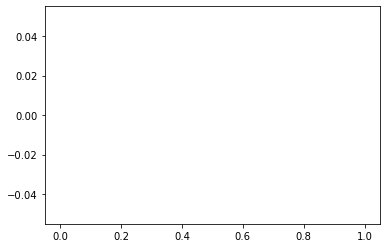

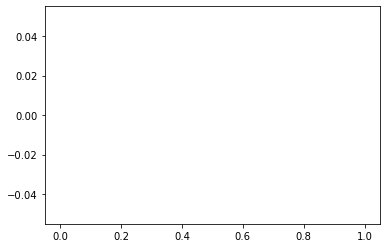

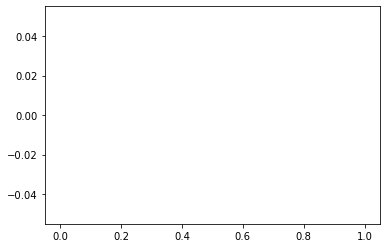

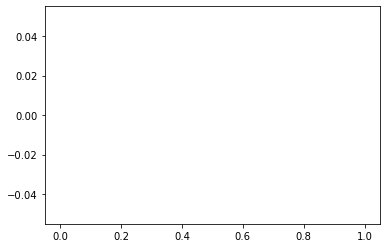

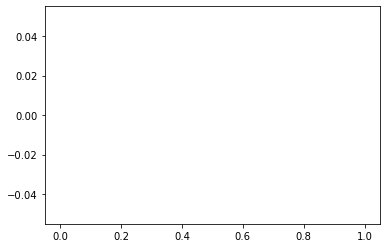

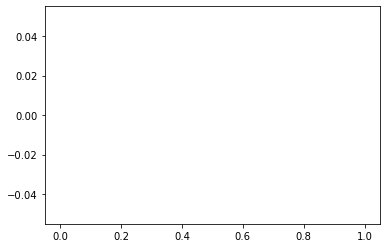

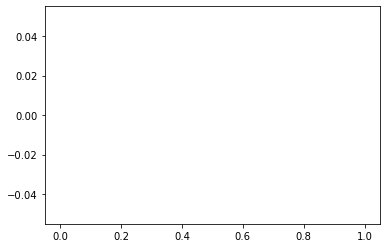

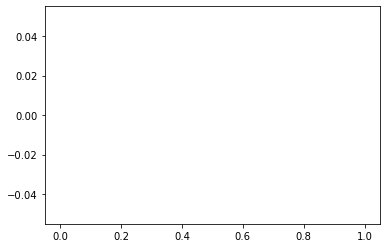

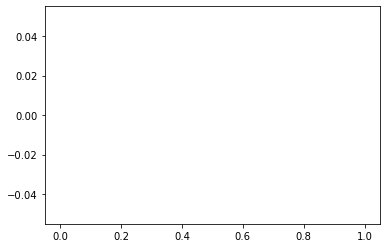

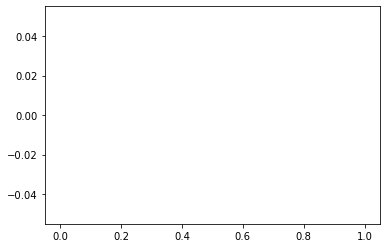

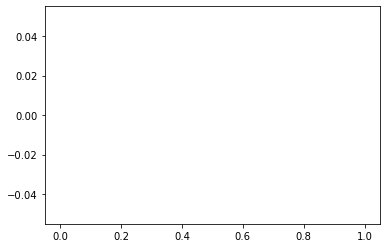

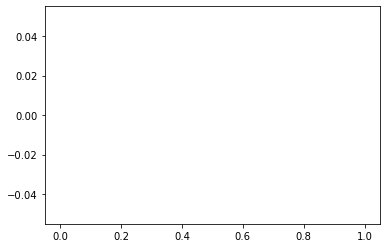

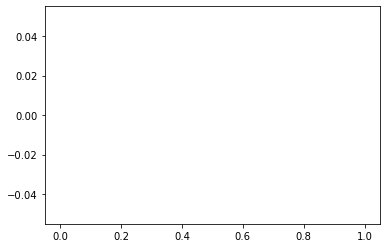

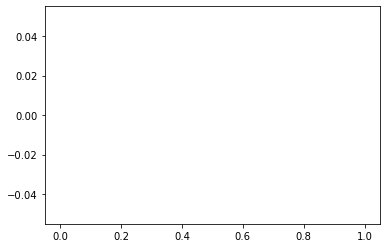

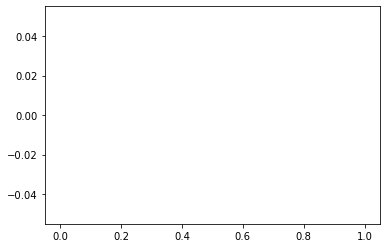

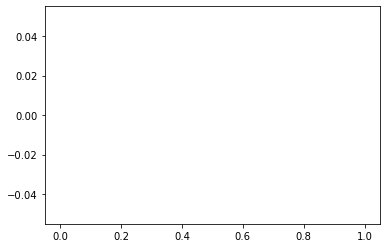

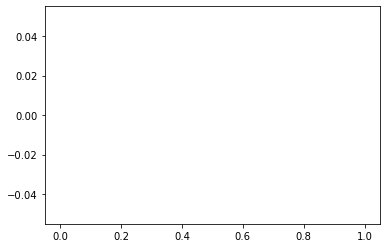

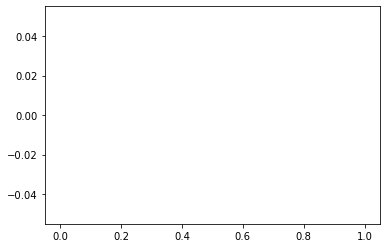

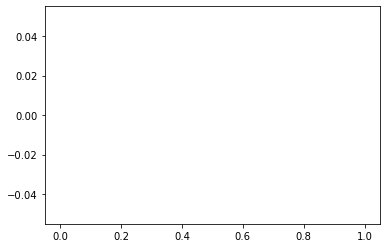

In [249]:
for subject in subject_list:
    
    for sound in ['music','speech']:
        plt.hist(sr[sound][subject])
    plt.show()
    plt.close()

In [176]:
d_engagement['speech'][subject][5,:]


array([-3.64271566, -3.64271566, -3.64271566, ..., -3.64271566,
       -3.64271566, -3.64271566])

In [150]:
index=dict()
for sound in sound_list:
    
    index[sound]={}
    for subject in subject_list:

        aa=set()
        for i in ind[sound][subject]:
            aa.update(np.arange(i,i+window_length))
            
        index[sound][subject]=list(aa)

            
for subject in subject_list:
    m=min(len(index['speech'][subject]), len(index['music'][subject]))
    for sound in ['speech', 'music']:
        index[sound][subject]=index[sound][subject][:m]
        

The indices of the time steps of the binarized dataset corresponding to the most correlated time windows (computed above), are computed in the following way. Below is for the moment when each subject is particularly correlated with the others.

In [114]:

#%%
entropy=dict()
mean_eng=dict()
burstiness=dict()
n_iterations=100
engagement=dict()
engagementr={}
engagement_null_mean={}
engagement_null_std={}

sound='rest'
for isub, subject in enumerate(subject_list):
    
    zdata=sv.loading( path+"data_"+datatipe+'_'+subject) #loading the data of the three conditions that we saved before 

    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
        
    m=len(list(index['speech'][subject]))
    print(m, len(list(index['music'][subject])))      

            
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)
        
for sound in ['music', 'speech']:
    engagement[sound]={}
    engagementr[sound]={}
    
    for subject in subject_list:
        zdata=sv.loading( path+"data_"+datatipe+'_'+subject) #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)
        
        
        corr_thres=np.percentile(dcorr[sound][subject], 99)
        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index[sound][subject],:]

        engagementt=np.sum(aval, axis=0)

        engagement[sound][subject]=(engagementt-engagement_null_mean[subject])/engagement_null_std[subject]
            
        engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        print(engagement[sound][subject])

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/matte/OneDrive/Documenti/matteo/data_hgenv_down100_sub-14c725b6b803'